In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve2d
from scipy.misc import imresize

import tensorflow as tf

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = expanduser('~/data/images/Tkacik/cd01A')
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)
old_size = patches[0].shape[0]
height = 32
width = 32
resized_pixels_to_degree = float(height/old_size) * pixelsToDeg
images = [imresize(p, (height, width), interp='bilinear') for p in patches]

Only 70 files in directory.


In [3]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing = 1./pixelsToDeg # number of degree spacing between pixels
normalize = 'divisive'
contrast = 0.35
signal = np.array(np.load('signal_3_23.npy'))

In [4]:
signal.shape

(200,)

In [5]:
microns_per_degree = 50.0 # depends on species; this is for salamander
photoreceptor_width = 10.0/microns_per_degree # salamander photoreceptors have width of 10-20 microns
retina_width = 4000.0/microns_per_degree # salamander retina is about 4 mm
frequency_spacing = 1./retina_width # this is the lowest non-DC frequency we can estimate
highest_frequency = 0.5/photoreceptor_width # this is the highest frequency we can estimate (Nyquist freq.)

N = retina_width//photoreceptor_width
freqs = np.linspace(0, highest_frequency, N//2 + 1)
space = np.concatenate([np.linspace(-0.5*retina_width, 0, N//2 + 1)[:-1], np.linspace(0, 0.5*retina_width, N//2 + 1)])

/home/lane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/home/lane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


In [6]:
len(freqs)

200

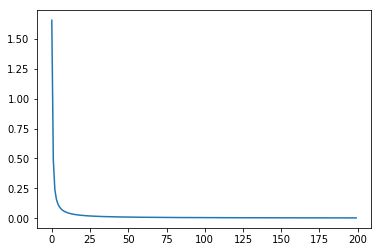

In [7]:
plt.plot(signal)

/home/lane/.local/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


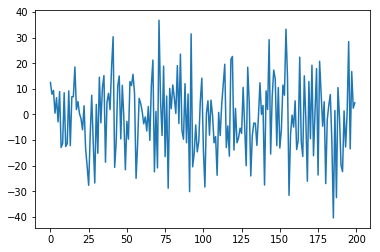

In [8]:
plt.plot(np.fft.rfft(np.random.randn(399)))

In [9]:
a = np.random.randn(399)

In [10]:
np.fft.rfft(a).shape

(200,)

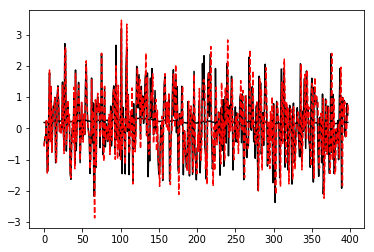

In [11]:
plt.plot(np.fft.irfft(np.fft.rfft(a)), 'k')
plt.plot(np.fft.irfft(np.fft.rfft(a) * signal), 'k')
plt.plot(a, 'r--')

In [12]:
def generate_spatial_signals(batch_size, signal=signal):
    # We generate white noise sequences, then multiply their frequency spectra
    # by the signal frequency spectra to make it look like a natural sequence.
    random_seq = [np.random.randn(2 * len(signal) - 1) for b in range(batch_size)]
    spatial_seq = [np.fft.irfft(np.fft.rfft(s) * signal) for s in random_seq]
    return np.stack(spatial_seq)

In [13]:
blah = generate_spatial_signals(32)

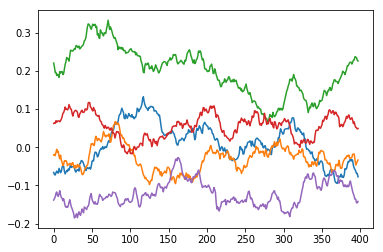

In [14]:
bloop = plt.plot(blah[:5].T)

# Get appropriately sized/shaped filters from retinal data.

In [15]:
microns_per_degree = 50.0 # depends on species; this is for salamander
photoreceptor_width = 10.0/microns_per_degree # salamander photoreceptors have width of 10-20 microns
retina_width = 4000.0/microns_per_degree # salamander retina is about 4 mm
frequency_spacing = 1./retina_width # this is the lowest non-DC frequency we can estimate
highest_frequency = 0.5/photoreceptor_width # this is the highest frequency we can estimate (Nyquist freq.)

N = int(retina_width/photoreceptor_width) - 1
freqs = np.linspace(0, highest_frequency, N//2 + 1)
space = np.concatenate([np.linspace(-0.5*retina_width, 0, N//2 + 1)[:-1], np.linspace(0, 0.5*retina_width, N//2 + 1)])

In [16]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells(space_mode='peak')
cells['bipolar'] = load_bipolar_cells(space_mode='peak')
cells['amacrine'] = load_amacrine_cells(space_mode='peak')
cells['horizontal'] = load_horizontal_cells(space_mode='peak')

In [17]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for s, rf in cells[c]:
        this_cell_interp = interp1d(s, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(space))
        
average_ganglion_rf = np.mean(receptive_fields['ganglion'], axis=0)

In [18]:
data_path = expanduser('~/data/kastner/receptive_fields/')
spatialDelta = 0.05 # mm
micronsPerDeg = 50.
ganglion_rfs = {
    'fast_on': np.loadtxt(data_path + 'linesRF1.txt').reshape((126, 101, -1)),
    'fast_off_adapting': np.loadtxt(data_path + 'linesRF19.txt').reshape((-1, 101, 96)),
    'fast_off_sensitizing': np.loadtxt(data_path + 'linesRF8.txt').reshape((-1, 101, 96)),
    'medium_off_adapting': np.loadtxt(data_path + 'linesRF29.txt').reshape((-1, 101, 96)),
    'slow_off': np.loadtxt(data_path + 'linesRF17.txt').reshape((-1, 101, 96)),
}

for celltype in ganglion_rfs.keys():
    for rf in ganglion_rfs[celltype]:
        # since receptive fields are noisy, use PCA
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        this_space = get_space(g_pca, spatialDelta, micronsPerDeg, kind='peak')
        
        rf_interp = interp1d(this_space, sign_of_pc*g_pca, kind='slinear', bounds_error=False, fill_value=[0])

        receptive_fields[celltype].append(rf_interp(space))

In [19]:
corr_map = {}
for celltype in receptive_fields.keys():
    corr_map[celltype] = np.zeros((len(receptive_fields[celltype]), len(receptive_fields[celltype])))
    for idr1, rf1 in tqdm(enumerate(receptive_fields[celltype])):
        for idr2 in range(idr1+1, len(receptive_fields[celltype])):
            rf2 = receptive_fields[celltype][idr2]
            corr_map[celltype][idr1, idr2] = pearsonr(rf1, rf2)[0]

unduplicated_receptive_fields = collections.defaultdict(list)
duplicates = collections.defaultdict(list)

for celltype in corr_map.keys():
    these_dups = []
    for row in corr_map[celltype]:
        these_dups.append([i for i in range(len(row)) if row[i] == 1.0])
    duplicates[celltype] = np.unique(np.hstack(these_dups))
    
unduplicated_receptive_fields = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    for idr, rf in enumerate(receptive_fields[celltype]):
        if idr not in duplicates[celltype]:
            unduplicated_receptive_fields[celltype].append(rf)
            
receptive_fields = unduplicated_receptive_fields.copy()
del unduplicated_receptive_fields

28it [00:00, 931.16it/s]
2it [00:00, 12690.78it/s]
2it [00:00, 11554.56it/s]
2it [00:00, 7724.32it/s]
126it [00:00, 209.18it/s]
772it [00:22, 34.18it/s] 
249it [00:02, 103.72it/s]
321it [00:03, 82.65it/s] 
253it [00:02, 104.92it/s]


In [20]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0)
def center_and_surround(space, center_width, surround_width, center_strength, surround_strength):
    return diff_of_gauss_mu0(space, abs(center_width), abs(surround_width),
                            -abs(center_strength), abs(surround_strength))

In [21]:
center_widths = collections.defaultdict(list)
surround_widths = collections.defaultdict(list)
center_strengths = collections.defaultdict(list)
surround_strengths = collections.defaultdict(list)
fit_failures = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        
        for idg, g in tqdm(enumerate(receptive_fields[celltype])):
            try:
                popt_this, pcov = curve_fit(center_and_surround, space, g, p0=[1.5, 3.5, -10, 30])
                center_id = np.argmin(abs(popt_this[:2]))
                surround_id = 1 ^ center_id
                center_widths[celltype].append(abs(popt_this[center_id]))
                surround_widths[celltype].append(abs(popt_this[surround_id]))
                center_strengths[celltype].append(popt_this[center_id+2])
                surround_strengths[celltype].append(popt_this[surround_id+2])
#                 plt.plot(space, diff_of_gauss_mu0(space, *popt_this), color=np.random.rand(3), alpha=0.6)
            except:
                fit_failures[celltype].append(idg)
            
                # just set params to median across cells
                # this way the params are still aligned with the receptive field id
                center_widths[celltype].append(np.median(center_widths[celltype]))
                surround_widths[celltype].append(np.median(surround_widths[celltype]))
                center_strengths[celltype].append(np.median(center_strengths[celltype]))
                surround_strengths[celltype].append(np.median(surround_strengths[celltype]))
                
#                 print("Couldn't fit cell %d" %idg)

28it [00:16,  1.35s/it]
58it [00:21,  3.25it/s]
772it [02:33,  6.85it/s]
217it [01:13,  3.32it/s]
159it [00:43,  5.44it/s]
148it [01:30,  1.02s/it]


In [22]:
median_center_widths = {}
for celltype in center_widths.keys():
    cws = np.array(center_widths[celltype])
    sws = np.array(surround_widths[celltype])
    css = np.array(center_strengths[celltype])
    sss = np.array(surround_strengths[celltype])
#     mean_center_widths[celltype] = np.mean(cws[cws < 500])
#     mean_surround_width = np.mean(sws[sws < 500])
#     mean_center_strength = np.mean(css[abs(css) < 500])
#     mean_surround_strength = np.mean(sss[abs(sss) < 500])
    
    median_center_widths[celltype] = np.median(abs(cws))
    median_surround_width = np.median(abs(sws))
    median_center_strength = np.median(-abs(css))
    median_surround_strength = np.median(abs(sss))
#     plt.plot(space, diff_of_gauss_mu0(space, median_center_widths[celltype], median_surround_width,
#                                      median_center_strength, median_surround_strength), label=celltype)
# plt.legend(frameon=False, fontsize=9, loc='lower left')
# adjust_spines(plt.gca())

In [23]:
horz_pfs_full = get_horizontal_projective_field(conv_mode='full')
horz_pfs_same = get_horizontal_projective_field(conv_mode='same')
ama_pfs_full = get_amacrine_projective_field(conv_mode='full')
ama_pfs_same = get_amacrine_projective_field(conv_mode='same')

space_h_full, horz_pf_full, horz_sem_full = get_mean(horz_pfs_full)
space_h_same, horz_pf_same, horz_sem_same = get_mean(horz_pfs_same)
space_a_full, ama_pf_full, ama_sem_full = get_mean(ama_pfs_full)
space_a_same, ama_pf_same, ama_sem_same = get_mean(ama_pfs_same)

In [24]:
horz_pf_interp = interp1d(space_h_full, horz_pf_full, kind='slinear', bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space_a_full, ama_pf_full, kind='slinear', bounds_error=False, fill_value=[0])

horz_pf = horz_pf_interp(space)
ama_pf = ama_pf_interp(space)

In [25]:
horz_pf /= np.sum(horz_pf)
ama_pf /= np.sum(ama_pf)

In [26]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing = 1./pixelsToDeg # number of degree spacing between pixels
normalize = 'divisive'
contrast = 0.35
signal = np.array(np.load('signal_3_23.npy'))

In [27]:
input_noise = 0.098762200628786892
output_noise = 0.35
target_power = 54.131410989171826

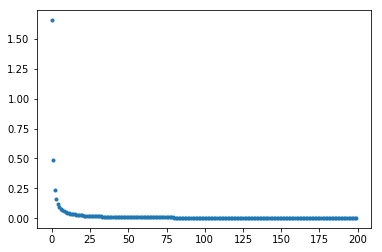

In [28]:
plt.plot(signal, '.')

1.92576130327


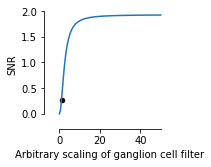

In [29]:
fig = plt.gcf()
fig.set_size_inches((2,2))
average_ganglion_fft = abs(np.fft.rfft(average_ganglion_rf))
print(get_snr(input_noise, output_noise, signal, 1000*average_ganglion_fft, mode='variance'))
snrs = [get_snr(input_noise, output_noise, signal, c*average_ganglion_fft) for c in np.linspace(0,50,100)]
plt.plot(np.linspace(0,50,100), snrs)
adjust_spines(plt.gca())
plt.xlabel('Arbitrary scaling of ganglion cell filter')
plt.ylabel('SNR')

# SNR = 0.269 is total SNR from ganglion recordings of 112 repeats to 30 seconds natural scenes
def find_filt_const(filt_const):
    this_snr = get_snr(input_noise, output_noise, signal, filt_const*average_ganglion_fft, mode='variance')
    return (this_snr - 0.26912469)**2

filt_const_opt = scipy.optimize.minimize_scalar(find_filt_const)

our_snr = get_snr(input_noise, output_noise, signal, filt_const_opt.x*average_ganglion_fft, mode='variance')

plt.scatter(filt_const_opt.x, our_snr, s=20, color='k')

In [30]:
resolution = 150
horz_weights = np.linspace(0,1,resolution)
center_weights = np.linspace(0,1,resolution)

In [31]:
median_center_widths

{'fast_off_adapting': 1.6921005209471627,
 'fast_off_sensitizing': 2.0456543257003039,
 'fast_on': 2.1703662900605498,
 'ganglion': 1.3731413963691115,
 'medium_off_adapting': 1.555772399380934,
 'slow_off': 1.5248731503974167}

In [32]:
len(signal)

200

In [33]:
init_filt_const = 10.9
info_maps = collections.defaultdict(list) # one info map per celltype (since they will be a function of center width)
failures = collections.defaultdict(list)
detailed_failures = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
        center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf
        
        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)
        
#         print('Information map for %s cells.' %celltype)
        
        infomap = np.zeros((resolution, resolution))
        for idh,hw in tqdm(enumerate(horz_weights)):
            for idc,cw in enumerate(center_weights):
                rf = rf_model(hw, cw)
                rf_filt = abs(np.fft.rfft(rf))
                
                # constrain model
                def constrain_filt_power(filt_const):
                    size = len(rf_filt)
                    output_power = np.sum((signal*filt_const*rf_filt)**2 
                                          + (input_noise*filt_const*rf_filt)**2
                                          + output_noise**2)
                    
                    return (target_power - output_power)**2

                filt_const_opt = scipy.optimize.minimize(constrain_filt_power, init_filt_const)
                iterations = 0
                new_init_filt_const = init_filt_const
                while not filt_const_opt.success:
                    iterations += 1
                    new_init_filt_const *= 10
                    filt_const_opt = scipy.optimize.minimize(constrain_filt_power, new_init_filt_const)
                    if iterations > 10:
                        detailed_failures[celltype] = filt_const_opt
                        break
                
                filt_const = abs(filt_const_opt['x'])
                
                if not filt_const_opt.success:
                    failures[celltype].append([hw, cw])

                signal_power = (filt_const * rf_filt * signal)**2
                noise_power = (filt_const * rf_filt * input_noise)**2 + output_noise**2
                infomap[idh,idc] = 0.5*np.sum(np.log2(1 + signal_power/noise_power))
        info_maps[celltype] = infomap

150it [00:36,  4.16it/s]
150it [00:36,  4.07it/s]
150it [00:36,  4.09it/s]
150it [00:36,  4.15it/s]
150it [00:36,  4.14it/s]
150it [00:36,  4.15it/s]


In [68]:
# celltype = 'medium_off_adapting'
celltype = 'fast_off_adapting'
center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

def rf_model(horz_weight, center_weight):
    return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)

In [45]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))

In [46]:
iterations = 25

fits = collections.defaultdict(list)
all_params = collections.defaultdict(list)
mean_squared_errors = collections.defaultdict(list)
abs_errors = collections.defaultdict(list)
variances = collections.defaultdict(list)

horz_pf_interp = interp1d(space, horz_pf, bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space, ama_pf, bounds_error=False, fill_value=[0])

def rf_model(width, mean, ama_pos, horz_pos, horz_weight, center_weight):
    horz_weight = sigmoid(horz_weight)
    center_weight = sigmoid(center_weight)

    center = gaussian(x=space, sigma=abs(width), mu=mean)
    center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

    new_ama_space = np.linspace(np.min(space)-ama_pos, np.max(space)-ama_pos, len(space))
    new_horz_space = np.linspace(np.min(space)-horz_pos, np.max(space)-horz_pos, len(space))
    ama = ama_pf_interp(new_ama_space)/np.sum(ama_pf_interp(new_ama_space))
    horz = horz_pf_interp(new_horz_space)/np.sum(horz_pf_interp(new_horz_space))

    return center_weight*center + (1-center_weight)*(horz_weight*horz + (1-horz_weight)*ama)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']: 
                
        popts = []
        params = []
        
#         print('Fitting ganglion celltype %s.' %celltype)
        for i,rf in tqdm(enumerate(receptive_fields[celltype])):
            
            def model_error_to_ganglion_cells(weights):
                width, mean, ama_pos, horz_pos, hw, cw = weights
                modeled_rf = rf_model(width, mean, ama_pos, horz_pos, hw, cw)
                normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
                # add regularization to ama_pos and horz_pos
                return sum(abs(normed_rf - rf)**2) #+ 0.005*(ama_pos**2 + horz_pos**2)

            best_fit_err = np.inf
            for itr in range(iterations):
                # center width
                # center position
                # ama position
                # horz position
                # horz/ama weight
                # center/surr weight
                this_popt = minimize(model_error_to_ganglion_cells, np.hstack([center_widths[celltype][i]+0.5*np.random.randn(1),
                                                                               0.1*np.random.randn(3),
                                                                               np.random.randn(2)]),
                                    method='L-BFGS-B',
                                    bounds=[(1e-6,None), (np.min(space),np.max(space)), (np.min(space),np.max(space)),
                                           (np.min(space),np.max(space)), (None,None), (None,None)])
                if this_popt.fun < best_fit_err:
                    best_fit_err = this_popt.fun
                    popt = this_popt
            
            # get mean squared error
            modeled_rf = rf_model(*popt.x)
            normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
            mse = np.mean((normed_rf - rf)**2)

            # translate hw and cw params back into [0,1] range
            x = sigmoid(popt.x[-2:])

            popts.append(x)
            params.append(popt.x)
            abs_errors[celltype].append(popt.fun)
            mean_squared_errors[celltype].append(mse)
            variances[celltype].append(np.var(rf))

        fits[celltype] = np.stack(popts)
        all_params[celltype] = np.stack(params)

0it [00:00, ?it/s]/home/lane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/lane/.local/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:634: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/home/lane/.local/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:635: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
2it [00:46, 21.14s/it]/home/lane/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
28it [11:57, 33.22s/it]
58it [29:34, 31.77s/it]
66it [32:55, 25.91s/it]

KeyboardInterrupt: 

In [47]:
fits = np.load('fits_3_23.npy').item()
all_params = np.load('params_3_23.npy').item()
variances = np.load('variances_3_23.npy').item()
mean_squared_errors = np.load('mse_3_23.npy').item()
abs_errors = np.load('abserrs_3_23.npy').item()

In [48]:
fits.keys()

dict_keys(['fast_off_sensitizing', 'slow_off', 'fast_off_adapting', 'ganglion', 'fast_on', 'medium_off_adapting'])

In [49]:
len(fits['medium_off_adapting'])

159

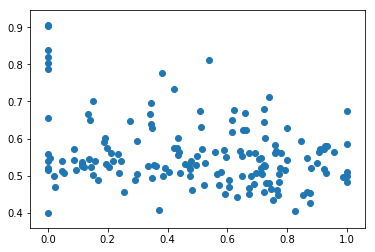

In [51]:
# 0th dimension is hw, second dimension is cw (1 - surround)
plt.scatter(fits['medium_off_adapting'][:,0], fits['medium_off_adapting'][:,1])

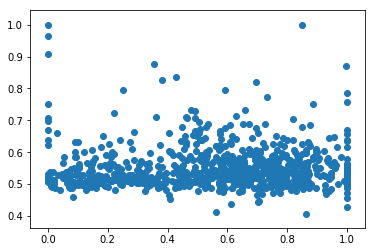

In [58]:
# 0th dimension is hw, second dimension is cw (1 - surround)
plt.scatter(fits['fast_off_adapting'][:,0], fits['fast_off_adapting'][:,1])

In [65]:
len(fits['fast_off_adapting'])

772

In [59]:
celltype = 'fast_off_adapting'

In [60]:
np.unravel_index(np.argmax(info_maps[celltype]), (resolution, resolution))

(0, 78)

In [63]:
center_weights[78]

0.52348993288590606

In [64]:
horz_weights[0]

0.0

In [69]:
info_maps[celltype][0, 78]

9.3790697176201405

In [62]:
info_maps[celltype][7, 79]

9.3678371603378103

In [56]:
horz_weights[7]

0.046979865771812082

In [57]:
center_weights[79]

0.53020134228187921

In [40]:
info_maps[celltype][7, 60]

5.4946557689000217

In [41]:
info_maps[celltype][130, 60]

7.2308688251805719

In [42]:
info_maps[celltype][7, 79]

9.4127817834488958

In [43]:
info_maps[celltype][80, 80]

9.3800150765770827

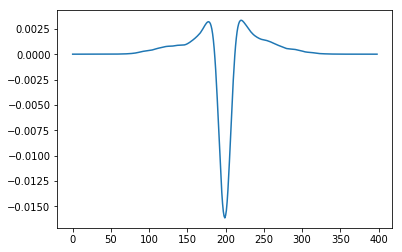

In [44]:
plt.plot(rf_model(0.5, 0.5))

# Gather collection of 1-D filters, sorted by information

In [66]:
np.unravel_index(np.argmax(info_maps[celltype]), (resolution, resolution))

(0, 78)

In [67]:
np.random.choice(50, 30, replace=False)

array([11,  6, 10, 16,  2, 40, 37, 47, 49, 26,  4, 27, 31, 41, 35, 48, 43,
       23, 28, 15,  8, 19, 22, 34, 39,  9, 45, 12,  7, 18])

In [89]:
# Sample from actual retinal ganglion parameters
celltype = 'medium_off_adapting'
# celltype = 'fast_off_adapting'
center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

def rf_model(horz_weight, center_weight):
    return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)

num_cells = len(fits[celltype])
opt_hw, opt_cw = np.unravel_index(np.argmax(info_maps[celltype]), (resolution, resolution))
max_filters = 30
cell_ids = np.random.choice(num_cells, max_filters, replace=False)
actual_cws = [center_weights[opt_cw]]
actual_hws = [horz_weights[opt_hw]]
chosen_filters = [rf_model(actual_hws[-1], actual_cws[-1])]
for cell_id in cell_ids:
    hw = fits[celltype][cell_id, 0]
    cw = fits[celltype][cell_id, 1]
    actual_cws.append(cw)
    actual_hws.append(hw)
    chosen_filters.append(rf_model(actual_hws[-1], actual_cws[-1]))

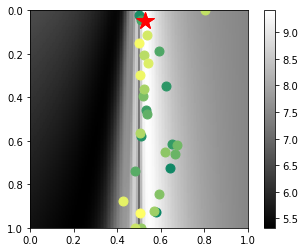

In [94]:
plt.imshow(info_maps[celltype], cmap='gray', extent=(center_weights[0], center_weights[-1], 
                                                     horz_weights[-1], horz_weights[0]))
colors = plt.cm.summer(np.linspace(0,1,max_filters))
for i, cw, hw in zip(range(max_filters), actual_cws, actual_hws):
    if i == 0:
        plt.plot(cw, hw, color='r', marker='*', markersize=18)
    else:
        plt.plot(cw, hw, color=colors[i], marker='.', markersize=18)
plt.plot(actual_cws[0], actual_hws[0], color='r', marker='*', markersize=18)
plt.colorbar()

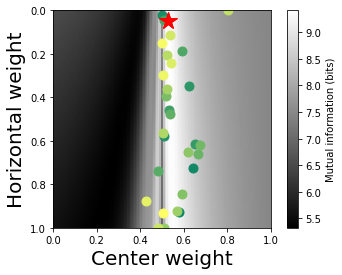

In [149]:
plt.imshow(info_maps[celltype], cmap='gray', extent=(center_weights[0], center_weights[-1], 
                                                     horz_weights[-1], horz_weights[0]))
colors = plt.cm.summer(np.linspace(0,1,max_filters))
for i, cw, hw in zip(range(max_filters), actual_cws, actual_hws):
    if i == 0:
        plt.plot(cw, hw, color='r', marker='*', markersize=18)
    else:
        plt.plot(cw, hw, color=colors[i], marker='.', markersize=18)
plt.plot(actual_cws[0], actual_hws[0], color='r', marker='*', markersize=18)
plt.colorbar(label='Mutual information (bits)')
plt.xlabel('Center weight', fontsize=20)
plt.ylabel('Horizontal weight', fontsize=20)

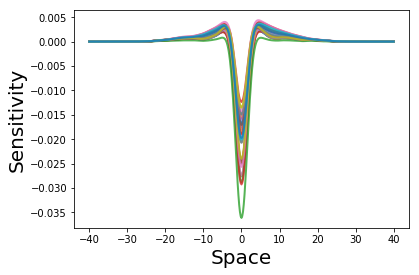

In [95]:
for f in chosen_filters:
    plt.plot(space, f, linewidth=2, alpha=0.8)
    plt.xlabel('Space', fontsize=20)
    plt.ylabel('Sensitivity', fontsize=20)

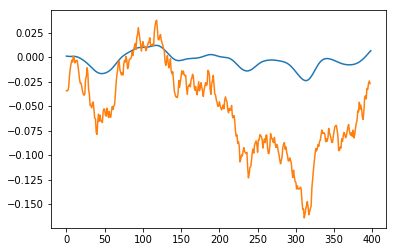

In [96]:
batch_size = 2
instance = generate_spatial_signals(batch_size, signal=signal)
plt.plot(np.convolve(f, instance[0], mode='same'))
plt.plot(-instance[0])

In [109]:
instance.shape

(2, 398)

In [97]:
def training_data(batch_size, diverse=False, num_filters=3):
    original_instances = 10 * generate_spatial_signals(batch_size)
    instances = original_instances + input_noise * np.random.randn(*original_instances.shape)
    
    if diverse:
        convolved_instances = np.stack(
            [np.stack(
                [np.convolve(
                    f, inst, mode='same') for inst in instances]) for f in chosen_filters[:num_filters]], axis=-1)
    else:
        convolved_instances = np.stack(
            [np.stack([np.convolve(chosen_filters[0],
                                   inst,
                                   mode='same') for inst in instances]) for fid in range(num_filters)],
            axis=-1)
    return (convolved_instances + output_noise * np.random.randn(*convolved_instances.shape), original_instances)

In [98]:
input_noise

0.09876220062878689

In [99]:
x, y = training_data(32, diverse=False)

In [100]:
y.shape

(32, 398)

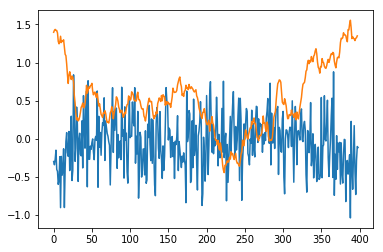

In [101]:
plt.plot(x[0, :, 0])
plt.plot(y[0])

In [102]:
np.var(y[0])

0.18731975240591409

In [103]:
np.var(x[0, :, 0])

0.12539861837482547

In [104]:
np.mean([np.var(y[j]) / (np.var(x[j, :, 0])) for j in range(32)])

1.4518005637094755

# Giant for loop

In [133]:
x, y = training_data(32, diverse=True, num_filters=1)

In [134]:
y.shape

(32, 398)

In [135]:
x.shape

(32, 399, 1)

In [ ]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
diverse_means = []
diverse_errors = []
homogenous_means = []
homogenous_errors = []
for channel_depth in range(1, max_filters+1):
    for idd, diversity in enumerate([True, False]):
        print('Channel depth %02d, diversity %d' %(channel_depth, idd))
        results = collections.defaultdict(list)
        g = tf.Graph()
        errors = []
        with g.as_default():
            distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, channel_depth))
            label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
            # inputs, num_outputs, kernel_size, stride=1
            flattened_input = tf.contrib.layers.flatten(distortion)
            out = tf.layers.dense(flattened_input, output_len)
        #     out = tf.layers.dense(layer1, 1)
            # layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
            # layer1 = tf.image.resize_bilinear(layer1, [height, width])
            mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
            opt = tf.train.GradientDescentOptimizer(0.001)
            train_op = opt.minimize(mse)

            with tf.Session() as sess:
                sess.run(tf.global_variables_initializer())
                for step in range(max_steps):
                    x, y = training_data(batch_size, diverse=diversity, num_filters=channel_depth)
                    update, error = sess.run([train_op, mse], feed_dict={distortion: x, label: y})
                    errors.append(error)
                    if step % 1000 == 0:
                        print('Error at step %04d is %0.4f' %(step, error))
                        results['input'].append(x)
                        results['labels'].append(y)
                        output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                        results['output'].append(output)
                    elif step == max_steps - 1:
                        print('Error at step %04d is %0.4f' %(step, error))
                        results['input'].append(x)
                        results['labels'].append(y)
                        output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                        results['output'].append(output)

        # Collect results.
        this_mse = np.mean([np.mean(
            (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
        this_err = sem([np.mean(
            (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
        if diversity:
            diverse_means.append(this_mse)
            diverse_errors.append(this_err)
        else:
            homogenous_means.append(this_mse)
            homogenous_errors.append(this_err)
        tf.reset_default_graph()

Channel depth 01, diversity 0
Error at step 0000 is 0.9682
Error at step 1000 is 0.8662
Error at step 2000 is 0.9637
Error at step 3000 is 0.9211
Error at step 4000 is 1.0107
Error at step 5000 is 0.8669
Error at step 6000 is 1.0762
Error at step 7000 is 1.1164
Error at step 8000 is 0.9554
Error at step 9000 is 0.9288
Error at step 10000 is 0.8550
Error at step 11000 is 0.7724
Error at step 12000 is 0.8016
Error at step 13000 is 0.9986
Error at step 14000 is 0.7775
Error at step 15000 is 0.9096
Error at step 16000 is 0.9887
Error at step 17000 is 0.8719
Error at step 18000 is 0.7526
Error at step 19000 is 0.7567
Error at step 20000 is 0.8725
Error at step 21000 is 0.7414
Error at step 22000 is 0.7636
Error at step 23000 is 0.7073
Error at step 24000 is 0.7519
Error at step 25000 is 0.7606
Error at step 26000 is 0.7342
Error at step 27000 is 0.7045
Error at step 28000 is 0.6851
Error at step 29000 is 0.7099
Error at step 29999 is 0.6664
Channel depth 01, diversity 1
Error at step 0000 i

In [139]:
len(diverse_means)

9

In [140]:
len(homogenous_means)

9

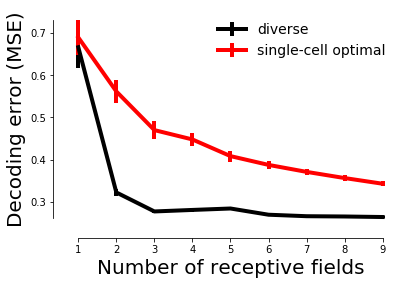

In [144]:
plt.errorbar(range(1, 10), diverse_means, yerr=diverse_errors, color='k', linewidth=4, label='diverse')
plt.errorbar(range(1, 10), homogenous_means, yerr=homogenous_errors, color='r', linewidth=4, label='single-cell optimal')
adjust_spines(plt.gca())
plt.xlabel('Number of receptive fields', fontsize=20)
plt.ylabel('Decoding error (MSE)', fontsize=20)
plt.legend(fontsize=14, frameon=False, loc='upper right')

# Collect results into errorbar chart

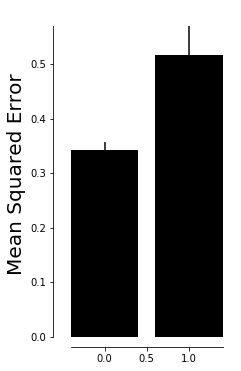

In [212]:
fig = plt.figure(figsize=(3,6))
plt.bar([0, 1], [diverse_mse, homogenous_mse], color='k', yerr=[diverse_errors, homogenous_errors])
plt.ylabel('Mean Squared Error', fontsize=20)
adjust_spines(plt.gca())

# Take the last N iterations

In [223]:
N = 3
homogenous_outputs = np.concatenate([homogenous_results['output'][-k] for k in range(N)])
homogenous_labels = np.concatenate([homogenous_results['labels'][-k] for k in range(N)])
diverse_outputs = np.concatenate([diverse_results['output'][-k] for k in range(N)])
diverse_labels = np.concatenate([diverse_results['labels'][-k] for k in range(N)])

In [224]:
homogenous_mse = np.mean([np.mean((homogenous_outputs[j] - homogenous_labels[j])**2) for j in range(N * batch_size)])
diverse_mse = np.mean([np.mean((diverse_outputs[j] - diverse_labels[j])**2) for j in range(N * batch_size)])
homogenous_errors = sem([np.mean((homogenous_outputs[j] - homogenous_labels[j])**2) for j in range(N * batch_size)])
diverse_errors = sem([np.mean((diverse_outputs[j] - diverse_labels[j])**2) for j in range(N * batch_size)])

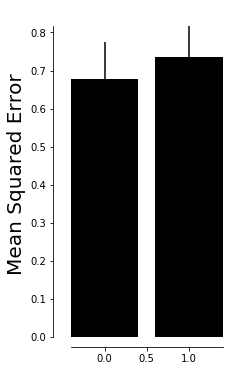

In [225]:
fig = plt.figure(figsize=(3,6))
plt.bar([0, 1], [diverse_mse, homogenous_mse], color='k', yerr=[diverse_errors, homogenous_errors])
plt.ylabel('Mean Squared Error', fontsize=20)
adjust_spines(plt.gca())

In [250]:
original_instances = 10 * generate_spatial_signals(batch_size)
instances = original_instances + input_noise * np.random.randn(*original_instances.shape)

convolved_instances = np.stack(
    [np.stack([np.convolve(f, inst, mode='same') for inst in instances]) for f in chosen_filters], axis=-1)
blah =  (convolved_instances + output_noise * np.random.randn(*convolved_instances.shape), original_instances)

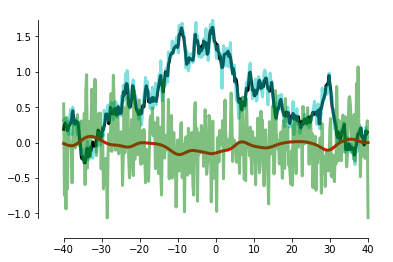

In [258]:
plt.plot(space[:-1], original_instances[0], linewidth=3, c='k')
plt.plot(space[:-1], instances[0], linewidth=3, c='c', alpha=0.5)
plt.plot(space, convolved_instances[0, :, 0], linewidth=3, c='r')
plt.plot(space, blah[0][0, :, 0], linewidth=3, c='g', alpha=0.5)
adjust_spines(plt.gca())

# Diverse optimal curve (backprop through RF parameters)

In [152]:
# Sample from actual retinal ganglion parameters
celltype = 'medium_off_adapting'
# celltype = 'fast_off_adapting'
center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

def encoder(horz_weight, center_weight):
    tf_center = tf.constant(center, dtype=tf.float32)
    tf_horz_pf = tf.constant(horz_pf, dtype=tf.float32)
    tf_ama_pf = tf.constant(ama_pf, dtype=tf.float32)
    tf_surround = (horz_weight * tf_horz_pf + (1 - horz_weight) * tf_ama_pf)
    return center_weight * tf_center + (1.0 - center_weight) * tf_surround

In [159]:
def training_data(batch_size):
    original_instances = 10 * generate_spatial_signals(batch_size)
    instances = original_instances + input_noise * np.random.randn(*original_instances.shape)
    
    return (np.expand_dims(instances, -1), original_instances)

In [160]:
x, y = training_data(10)
print(x.shape)
print(y.shape)

(10, 398, 1)
(10, 398)


In [ ]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 6
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET DATA READY
    distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    ideal_horz_weights = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.5))
    ideal_center_weights = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.5))
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
    noisy_encoded = encoded + tf.random_normal(shape=encoded.shape, mean=0.0, stddev=output_noise, name='output_noise')
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    out = tf.layers.dense(flattened_input, output_len)
    print('Flattened input has shape %s.' %(flattened_input.shape,))
    print('Out has shape %s.' %(out.shape,))
#     out = tf.layers.dense(layer1, 1)
    # layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
    # layer1 = tf.image.resize_bilinear(layer1, [height, width])
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(mse)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw = sess.run([train_op, mse, kernel, ideal_horz_weights, ideal_center_weights], feed_dict={distortion: x, label: y})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)

# Collect results.
this_mse = np.mean([np.mean(
    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem([np.mean(
    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 6).
Encoded has shape (128, 398, 6).
Noisy encoded has shape Tensor("add_24:0", shape=(128, 398, 6), dtype=float32).
Flattened input has shape (128, 2388).
Out has shape (128, 398).
Error at step 0000 is 1.1354
Error at step 1000 is 1.0807
Error at step 2000 is 0.5306
Error at step 3000 is 0.3937


In [172]:
results['hw'][-1]

array([ 0.49133468,  0.49369183,  0.48983511,  0.49447012,  0.50231278,
        0.48984861], dtype=float32)

In [173]:
results['cw'][-1]

array([ 0.49799651,  0.80649966,  0.88449723,  0.62694722, -0.03770896,
        0.41731054], dtype=float32)

In [174]:
all_hws = results['hw'][-1]
all_cws = results['cw'][-1]

In [177]:
[max([cw, 0]) for cw in all_cws]

[0.49799651, 0.80649966, 0.88449723, 0.62694722, 0, 0.41731054]

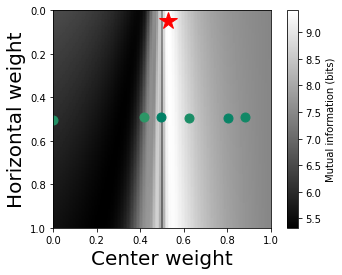

In [178]:
plt.imshow(info_maps[celltype], cmap='gray', extent=(center_weights[0], center_weights[-1], 
                                                     horz_weights[-1], horz_weights[0]))
colors = plt.cm.summer(np.linspace(0,1,max_filters))
for i, cw, hw in zip(range(channel_depth), [max([cw, 0]) for cw in all_cws], all_hws):
    plt.plot(cw, hw, color=colors[i], marker='.', markersize=18)
        
plt.plot(actual_cws[0], actual_hws[0], color='r', marker='*', markersize=18)
plt.colorbar(label='Mutual information (bits)')
plt.xlabel('Center weight', fontsize=20)
plt.ylabel('Horizontal weight', fontsize=20)

channel = 1

In [179]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 1
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET DATA READY
    distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    ideal_horz_weights = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.5))
    ideal_center_weights = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.5))
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
    noisy_encoded = encoded + tf.random_normal(shape=encoded.shape, mean=0.0, stddev=output_noise, name='output_noise')
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    out = tf.layers.dense(flattened_input, output_len)
    print('Flattened input has shape %s.' %(flattened_input.shape,))
    print('Out has shape %s.' %(out.shape,))
#     out = tf.layers.dense(layer1, 1)
    # layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
    # layer1 = tf.image.resize_bilinear(layer1, [height, width])
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(mse)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw = sess.run([train_op, mse, kernel, ideal_horz_weights, ideal_center_weights], feed_dict={distortion: x, label: y})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)

# Collect results.
this_mse = np.mean([np.mean(
    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem([np.mean(
    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 1).
Encoded has shape (128, 398, 1).
Noisy encoded has shape Tensor("add_4:0", shape=(128, 398, 1), dtype=float32).
Flattened input has shape (128, 398).
Out has shape (128, 398).
Error at step 0000 is 1.0254
Error at step 1000 is 1.0075
Error at step 2000 is 0.9340
Error at step 3000 is 0.6856
Error at step 4000 is 0.4458
Error at step 5000 is 0.3772
Error at step 6000 is 0.3330
Error at step 7000 is 0.3041
Error at step 8000 is 0.3149
Error at step 9000 is 0.2892
Error at step 10000 is 0.2833
Error at step 11000 is 0.2848
Error at step 12000 is 0.2640
Error at step 13000 is 0.2629
Error at step 14000 is 0.2535
Error at step 15000 is 0.2543
Error at step 16000 is 0.2376
Error at step 17000 is 0.2381
Error at step 18000 is 0.2344
Error at step 19000 is 0.2246
Error at step 20000 is 0.2225
Error at step 21000 is 0.2198
Error at step 22000 is 0.2206
Error at step 23000 is 0.2200
Error at step 24000 is 0.2033
Error at step 25000 is 0.2077
Error at step 26000 is 0

In [180]:
results['hw'][-1]

array([ 0.6426509], dtype=float32)

In [181]:
results['cw'][-1]

array([ 0.00881681], dtype=float32)

In [182]:
errors[-1]

0.19658569

In [184]:
all_hws = results['hw'][-1]
all_cws = results['cw'][-1]

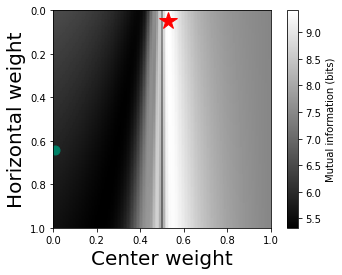

In [185]:
all_hws = results['hw'][-1]
all_cws = results['cw'][-1]

plt.imshow(info_maps[celltype], cmap='gray', extent=(center_weights[0], center_weights[-1], 
                                                     horz_weights[-1], horz_weights[0]))
colors = plt.cm.summer(np.linspace(0,1,max_filters))
for i, cw, hw in zip(range(channel_depth), [max([cw, 0]) for cw in all_cws], all_hws):
    plt.plot(cw, hw, color=colors[i], marker='.', markersize=18)
        
plt.plot(actual_cws[0], actual_hws[0], color='r', marker='*', markersize=18)
plt.colorbar(label='Mutual information (bits)')
plt.xlabel('Center weight', fontsize=20)
plt.ylabel('Horizontal weight', fontsize=20)

# L1 loss

In [186]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 1
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET DATA READY
    distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    ideal_horz_weights = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.5))
    ideal_center_weights = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.5))
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
    noisy_encoded = encoded + tf.random_normal(shape=encoded.shape, mean=0.0, stddev=output_noise, name='output_noise')
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    out = tf.layers.dense(flattened_input, output_len)
    print('Flattened input has shape %s.' %(flattened_input.shape,))
    print('Out has shape %s.' %(out.shape,))
#     out = tf.layers.dense(layer1, 1)
    # layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
    # layer1 = tf.image.resize_bilinear(layer1, [height, width])
    mse = tf.losses.absolute_difference(label, tf.squeeze(out))
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(mse)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw = sess.run([train_op, mse, kernel, ideal_horz_weights, ideal_center_weights], feed_dict={distortion: x, label: y})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)

# Collect results.
this_mse = np.mean([np.mean(
    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem([np.mean(
    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 1).
Encoded has shape (128, 398, 1).
Noisy encoded has shape Tensor("add_4:0", shape=(128, 398, 1), dtype=float32).
Flattened input has shape (128, 398).
Out has shape (128, 398).
Error at step 0000 is 0.7870
Error at step 1000 is 0.7808
Error at step 2000 is 0.8193
Error at step 3000 is 0.7746
Error at step 4000 is 0.7126
Error at step 5000 is 0.6570
Error at step 6000 is 0.6015
Error at step 7000 is 0.5527
Error at step 8000 is 0.4995
Error at step 9000 is 0.4732
Error at step 10000 is 0.4690
Error at step 11000 is 0.4379
Error at step 12000 is 0.4468
Error at step 13000 is 0.4179
Error at step 14000 is 0.4241
Error at step 15000 is 0.4207
Error at step 16000 is 0.4169
Error at step 17000 is 0.4140
Error at step 18000 is 0.4033
Error at step 19000 is 0.4027
Error at step 20000 is 0.4065
Error at step 21000 is 0.4011
Error at step 22000 is 0.4018
Error at step 23000 is 0.3901
Error at step 24000 is 0.3919
Error at step 25000 is 0.3931
Error at step 26000 is 0

In [187]:
results['hw'][-1]

array([ 0.58817554], dtype=float32)

In [188]:
results['cw'][-1]

array([ 0.05579584], dtype=float32)

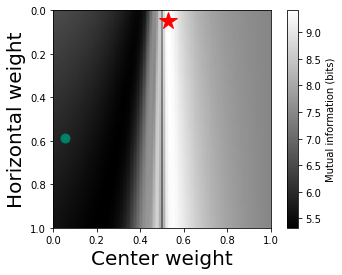

In [189]:
all_hws = results['hw'][-1]
all_cws = results['cw'][-1]

plt.imshow(info_maps[celltype], cmap='gray', extent=(center_weights[0], center_weights[-1], 
                                                     horz_weights[-1], horz_weights[0]))
colors = plt.cm.summer(np.linspace(0,1,max_filters))
for i, cw, hw in zip(range(channel_depth), [max([cw, 0]) for cw in all_cws], all_hws):
    plt.plot(cw, hw, color=colors[i], marker='.', markersize=18)
        
plt.plot(actual_cws[0], actual_hws[0], color='r', marker='*', markersize=18)
plt.colorbar(label='Mutual information (bits)')
plt.xlabel('Center weight', fontsize=20)
plt.ylabel('Horizontal weight', fontsize=20)

# P $\rightarrow$ 0

In [195]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 1
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET DATA READY
    distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    ideal_horz_weights = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.5))
    ideal_center_weights = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.5))
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
    noisy_encoded = encoded + tf.random_normal(shape=encoded.shape, mean=0.0, stddev=output_noise, name='output_noise')
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    out = tf.layers.dense(flattened_input, output_len)
    print('Flattened input has shape %s.' %(flattened_input.shape,))
    print('Out has shape %s.' %(out.shape,))
#     out = tf.layers.dense(layer1, 1)
    # layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
    # layer1 = tf.image.resize_bilinear(layer1, [height, width])
    mse = tf.reduce_mean(tf.pow(abs(label - tf.squeeze(out)), 0.9))
    opt = tf.train.GradientDescentOptimizer(0.0005)
    train_op = opt.minimize(mse)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw = sess.run([train_op, mse, kernel, ideal_horz_weights, ideal_center_weights], feed_dict={distortion: x, label: y})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)

# Collect results.
this_mse = np.mean([np.mean(
    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem([np.mean(
    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 1).
Encoded has shape (128, 398, 1).
Noisy encoded has shape Tensor("add_4:0", shape=(128, 398, 1), dtype=float32).
Flattened input has shape (128, 398).
Out has shape (128, 398).
Error at step 0000 is 0.7741
Error at step 1000 is 0.8635
Error at step 2000 is 0.7812
Error at step 3000 is 0.8461
Error at step 4000 is 0.8266
Error at step 5000 is 0.8267
Error at step 6000 is 0.7428
Error at step 7000 is 0.7386
Error at step 8000 is 0.7555
Error at step 9000 is 0.8080
Error at step 10000 is nan
Error at step 11000 is nan
Error at step 12000 is nan
Error at step 13000 is nan
Error at step 14000 is nan
Error at step 15000 is nan
Error at step 16000 is nan
Error at step 17000 is nan
Error at step 18000 is nan
Error at step 19000 is nan
Error at step 20000 is nan
Error at step 21000 is nan
Error at step 22000 is nan
Error at step 23000 is nan
Error at step 24000 is nan
Error at step 25000 is nan
Error at step 26000 is nan
Error at step 27000 is nan
Error at step 2800

# Now do this for variable channel depths

In [201]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
max_channel_depth = 10
all_results = []
all_errors = []

for channel_depth in range(1, max_channel_depth):
    results = collections.defaultdict(list)
    errors = []
    g = tf.Graph()
    with g.as_default():
        # GET DATA READY
        distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
        label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
        # inputs, num_outputs, kernel_size, stride=1

        # GET FILTERS READY
        ideal_horz_weights = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                             initializer=tf.constant_initializer(0.5))
        ideal_center_weights = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                               initializer=tf.constant_initializer(0.5))
        filters = []
        filtered_output = []
        for c in range(channel_depth):
            e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
            filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
        kernel = tf.stack(filters, axis=-1)
        kernel = tf.expand_dims(kernel, axis=1)
        print('Kernel has shape %s.' %(kernel.shape,))

        # CONVOLUTION WITH IDEAL RFS
        encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
        noisy_encoded = encoded + tf.random_normal(shape=encoded.shape, mean=0.0, stddev=output_noise, name='output_noise')
        print('Encoded has shape %s.' %(encoded.shape,))
        print('Noisy encoded has shape %s.' %(noisy_encoded,))

        flattened_input = tf.contrib.layers.flatten(noisy_encoded)
        out = tf.layers.dense(flattened_input, output_len)
        print('Flattened input has shape %s.' %(flattened_input.shape,))
        print('Out has shape %s.' %(out.shape,))
    #     out = tf.layers.dense(layer1, 1)
        # layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
        # layer1 = tf.image.resize_bilinear(layer1, [height, width])
        mse = tf.losses.absolute_difference(label, tf.squeeze(out))
        opt = tf.train.GradientDescentOptimizer(0.001)
        train_op = opt.minimize(mse)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for step in tqdm(range(max_steps)):
                x, y = training_data(batch_size)
                update, error, k, hw, cw = sess.run([train_op, mse, kernel, ideal_horz_weights, ideal_center_weights], feed_dict={distortion: x, label: y})
                errors.append(error)
                if step % 1000 == 0:
                    print('Error at step %04d is %0.4f' %(step, error))
                    results['input'].append(x)
                    results['labels'].append(y)
                    output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                    results['output'].append(output)
                    results['kernel'].append(k)
                    results['hw'].append(hw)
                    results['cw'].append(cw)
                elif step == max_steps - 1:
                    print('Error at step %04d is %0.4f' %(step, error))
                    results['input'].append(x)
                    results['labels'].append(y)
                    output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                    results['output'].append(output)
                    results['kernel'].append(k)
                    results['hw'].append(hw)
                    results['cw'].append(cw)

    # Collect results.
    this_mse = np.mean([np.mean(
        (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
    this_err = sem([np.mean(
        (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
    all_results.append(results)
    mean_errors.append(this_mse)
    sem_errors.append(this_err)
    all_errors.append(errors)
    tf.reset_default_graph()



  0%|          | 0/30000 [00:00<?, ?it/s]

Kernel has shape (399, 1, 1).
Encoded has shape (128, 398, 1).
Noisy encoded has shape Tensor("add_4:0", shape=(128, 398, 1), dtype=float32).
Flattened input has shape (128, 398).
Out has shape (128, 398).



  0%|          | 9/30000 [00:00<13:06, 38.13it/s]

Error at step 0000 is 0.8145



  3%|▎         | 1002/30000 [00:29<14:50, 32.56it/s]

Error at step 1000 is 0.7822


  7%|▋         | 2004/30000 [00:57<16:12, 28.78it/s]

Error at step 2000 is 0.7965


 10%|█         | 3004/30000 [01:26<16:06, 27.94it/s]

Error at step 3000 is 0.8055


 13%|█▎        | 4005/30000 [01:55<12:05, 35.84it/s]

Error at step 4000 is 0.6997


 17%|█▋        | 5004/30000 [02:22<15:14, 27.32it/s]

Error at step 5000 is 0.6130


 20%|██        | 6006/30000 [02:53<12:02, 33.23it/s]

Error at step 6000 is 0.5441


 23%|██▎       | 7009/30000 [03:20<08:43, 43.95it/s]

Error at step 7000 is 0.5016


 27%|██▋       | 8004/30000 [03:49<11:43, 31.26it/s]

Error at step 8000 is 0.4643


 30%|███       | 9003/30000 [04:17<08:29, 41.17it/s]

Error at step 9000 is 0.4737


 33%|███▎      | 10002/30000 [04:47<09:11, 36.27it/s]

Error at step 10000 is 0.4620


 37%|███▋      | 11005/30000 [05:19<09:54, 31.95it/s]

Error at step 11000 is 0.4278


 40%|████      | 12004/30000 [05:49<08:48, 34.03it/s]

Error at step 12000 is 0.4449


 43%|████▎     | 13004/30000 [06:17<06:40, 42.47it/s]

Error at step 13000 is 0.4386


 47%|████▋     | 14008/30000 [06:46<06:51, 38.83it/s]

Error at step 14000 is 0.4363


 50%|█████     | 15008/30000 [07:16<07:00, 35.61it/s]

Error at step 15000 is 0.4104


 53%|█████▎    | 16009/30000 [07:45<06:41, 34.83it/s]

Error at step 16000 is 0.4200


 57%|█████▋    | 17005/30000 [08:15<06:47, 31.92it/s]

Error at step 17000 is 0.4076


 60%|██████    | 18005/30000 [08:44<05:14, 38.17it/s]

Error at step 18000 is 0.4102


 63%|██████▎   | 19006/30000 [09:13<05:30, 33.30it/s]

Error at step 19000 is 0.4173


 67%|██████▋   | 20006/30000 [09:42<05:45, 28.96it/s]

Error at step 20000 is 0.4044


 70%|███████   | 21006/30000 [10:11<04:01, 37.30it/s]

Error at step 21000 is 0.3953


 73%|███████▎  | 22006/30000 [10:38<03:34, 37.22it/s]

Error at step 22000 is 0.3987


 77%|███████▋  | 23003/30000 [11:05<03:47, 30.74it/s]

Error at step 23000 is 0.3872


 80%|████████  | 24003/30000 [11:35<04:05, 24.39it/s]

Error at step 24000 is 0.3905


 83%|████████▎ | 25003/30000 [12:03<02:14, 37.13it/s]

Error at step 25000 is 0.3878


 87%|████████▋ | 26002/30000 [12:31<01:50, 36.34it/s]

Error at step 26000 is 0.3793


 90%|█████████ | 27006/30000 [13:01<01:17, 38.68it/s]

Error at step 27000 is 0.3770


 93%|█████████▎| 28005/30000 [13:30<00:52, 38.08it/s]

Error at step 28000 is 0.3766


 97%|█████████▋| 29004/30000 [13:59<00:31, 31.57it/s]

Error at step 29000 is 0.3736


100%|██████████| 30000/30000 [14:27<00:00, 34.59it/s]


Error at step 29999 is 0.3725
Kernel has shape (399, 1, 2).
Encoded has shape (128, 398, 2).
Noisy encoded has shape Tensor("add_8:0", shape=(128, 398, 2), dtype=float32).
Flattened input has shape (128, 796).
Out has shape (128, 398).


  0%|          | 9/30000 [00:00<13:49, 36.15it/s]

Error at step 0000 is 0.7724


  3%|▎         | 1002/30000 [00:29<12:40, 38.15it/s]

Error at step 1000 is 0.7933


  7%|▋         | 2005/30000 [01:02<15:46, 29.57it/s]

Error at step 2000 is 0.8211


 10%|█         | 3009/30000 [01:32<12:40, 35.49it/s]

Error at step 3000 is 0.7874


 13%|█▎        | 4008/30000 [02:03<13:04, 33.14it/s]

Error at step 4000 is 0.7304


 17%|█▋        | 5006/30000 [02:32<12:32, 33.20it/s]

Error at step 5000 is 0.6657


 20%|██        | 6003/30000 [03:02<15:20, 26.06it/s]

Error at step 6000 is 0.5643


 23%|██▎       | 7003/30000 [03:32<08:54, 42.99it/s]

Error at step 7000 is 0.5245


 27%|██▋       | 8006/30000 [04:02<10:10, 36.01it/s]

Error at step 8000 is 0.5001


 30%|███       | 9008/30000 [04:32<08:54, 39.30it/s]

Error at step 9000 is 0.4808


 33%|███▎      | 10006/30000 [05:01<07:50, 42.48it/s]

Error at step 10000 is 0.4669


 37%|███▋      | 11005/30000 [05:32<09:15, 34.21it/s]

Error at step 11000 is 0.4561


 40%|████      | 12004/30000 [06:02<11:16, 26.59it/s]

Error at step 12000 is 0.4605


 43%|████▎     | 13001/30000 [06:34<07:55, 35.73it/s]

Error at step 13000 is 0.4637


 47%|████▋     | 14004/30000 [07:05<07:49, 34.07it/s]

Error at step 14000 is 0.4408


 50%|█████     | 15004/30000 [07:34<07:06, 35.17it/s]

Error at step 15000 is 0.4396


 53%|█████▎    | 16003/30000 [08:06<06:57, 33.52it/s]

Error at step 16000 is 0.4345


 57%|█████▋    | 17005/30000 [08:35<06:29, 33.39it/s]

Error at step 17000 is 0.4370


 60%|██████    | 18004/30000 [09:07<07:54, 25.29it/s]

Error at step 18000 is 0.4327


 63%|██████▎   | 19004/30000 [09:38<05:21, 34.17it/s]

Error at step 19000 is 0.4220


 67%|██████▋   | 20005/30000 [10:09<05:24, 30.81it/s]

Error at step 20000 is 0.4217


 70%|███████   | 21004/30000 [10:38<05:17, 28.35it/s]

Error at step 21000 is 0.4151


 73%|███████▎  | 22004/30000 [11:07<04:35, 29.03it/s]

Error at step 22000 is 0.4094


 77%|███████▋  | 23006/30000 [11:36<03:30, 33.28it/s]

Error at step 23000 is 0.4132


 80%|████████  | 24005/30000 [12:05<02:49, 35.28it/s]

Error at step 24000 is 0.4034


 83%|████████▎ | 25004/30000 [12:36<03:21, 24.83it/s]

Error at step 25000 is 0.4035


 87%|████████▋ | 26007/30000 [13:05<01:48, 36.66it/s]

Error at step 26000 is 0.4039


 90%|█████████ | 27008/30000 [13:34<01:37, 30.57it/s]

Error at step 27000 is 0.3974


 93%|█████████▎| 28009/30000 [14:06<00:55, 35.65it/s]

Error at step 28000 is 0.3950


 97%|█████████▋| 29006/30000 [14:36<00:26, 37.45it/s]

Error at step 29000 is 0.3883


100%|██████████| 30000/30000 [15:06<00:00, 34.59it/s]


Error at step 29999 is 0.3894
Kernel has shape (399, 1, 3).
Encoded has shape (128, 398, 3).
Noisy encoded has shape Tensor("add_12:0", shape=(128, 398, 3), dtype=float32).
Flattened input has shape (128, 1194).
Out has shape (128, 398).


  0%|          | 6/30000 [00:00<20:21, 24.55it/s]

Error at step 0000 is 0.8437


  3%|▎         | 1008/30000 [00:28<11:23, 42.45it/s]

Error at step 1000 is 0.8030


  7%|▋         | 2005/30000 [00:56<13:51, 33.67it/s]

Error at step 2000 is 0.8627


 10%|█         | 3006/30000 [01:25<13:21, 33.67it/s]

Error at step 3000 is 0.7720


 13%|█▎        | 4009/30000 [01:53<11:45, 36.85it/s]

Error at step 4000 is 0.7554


 17%|█▋        | 5007/30000 [02:21<10:33, 39.46it/s]

Error at step 5000 is 0.6105


 20%|██        | 6002/30000 [02:50<14:05, 28.37it/s]

Error at step 6000 is 0.5387


 23%|██▎       | 7002/30000 [03:20<11:29, 33.35it/s]

Error at step 7000 is 0.5086


 27%|██▋       | 8009/30000 [03:49<09:24, 38.98it/s]

Error at step 8000 is 0.4862


 30%|███       | 9005/30000 [04:18<11:28, 30.49it/s]

Error at step 9000 is 0.4696


 33%|███▎      | 10007/30000 [04:47<08:00, 41.59it/s]

Error at step 10000 is 0.4731


 37%|███▋      | 11006/30000 [05:17<07:41, 41.12it/s]

Error at step 11000 is 0.4602


 40%|████      | 12005/30000 [05:48<12:04, 24.84it/s]

Error at step 12000 is 0.4499


 43%|████▎     | 13007/30000 [06:17<08:24, 33.70it/s]

Error at step 13000 is 0.4514


 47%|████▋     | 14005/30000 [06:45<08:00, 33.27it/s]

Error at step 14000 is 0.4389


 50%|█████     | 15005/30000 [07:15<07:45, 32.20it/s]

Error at step 15000 is 0.4306


 53%|█████▎    | 16003/30000 [07:44<09:21, 24.93it/s]

Error at step 16000 is 0.4334


 57%|█████▋    | 17004/30000 [08:14<07:29, 28.89it/s]

Error at step 17000 is 0.4267


 60%|██████    | 18003/30000 [08:45<05:31, 36.21it/s]

Error at step 18000 is 0.4290


 63%|██████▎   | 19006/30000 [09:14<05:39, 32.40it/s]

Error at step 19000 is 0.4169


 67%|██████▋   | 20006/30000 [09:43<05:57, 27.95it/s]

Error at step 20000 is 0.4199


 70%|███████   | 21005/30000 [10:12<03:42, 40.38it/s]

Error at step 21000 is 0.4144


 73%|███████▎  | 22005/30000 [10:42<05:28, 24.36it/s]

Error at step 22000 is 0.4076


 77%|███████▋  | 23004/30000 [11:12<04:18, 27.08it/s]

Error at step 23000 is 0.4049


 80%|████████  | 24001/30000 [11:41<02:23, 41.77it/s]

Error at step 24000 is 0.4029


 83%|████████▎ | 25004/30000 [12:11<01:59, 41.84it/s]

Error at step 25000 is 0.4019


 87%|████████▋ | 26004/30000 [12:40<02:20, 28.53it/s]

Error at step 26000 is 0.4029


 90%|█████████ | 27001/30000 [13:10<01:23, 35.86it/s]

Error at step 27000 is 0.4036


 93%|█████████▎| 28004/30000 [13:40<01:13, 27.21it/s]

Error at step 28000 is 0.3992


 97%|█████████▋| 29006/30000 [14:11<00:39, 25.28it/s]

Error at step 29000 is 0.3970


100%|██████████| 30000/30000 [14:41<00:00, 34.02it/s]


Error at step 29999 is 0.3946
Kernel has shape (399, 1, 4).
Encoded has shape (128, 398, 4).
Noisy encoded has shape Tensor("add_16:0", shape=(128, 398, 4), dtype=float32).
Flattened input has shape (128, 1592).
Out has shape (128, 398).


  0%|          | 5/30000 [00:00<51:33,  9.70it/s]  

Error at step 0000 is 0.8795


  3%|▎         | 1004/30000 [00:30<22:34, 21.41it/s]

Error at step 1000 is 0.7706


  7%|▋         | 2003/30000 [01:00<13:57, 33.43it/s]

Error at step 2000 is 0.8029


 10%|█         | 3006/30000 [01:31<12:59, 34.62it/s]

Error at step 3000 is 0.8005


 13%|█▎        | 4004/30000 [02:01<14:53, 29.11it/s]

Error at step 4000 is 0.6614


 17%|█▋        | 5007/30000 [02:32<12:06, 34.42it/s]

Error at step 5000 is 0.5629


 20%|██        | 6006/30000 [03:02<10:58, 36.42it/s]

Error at step 6000 is 0.5212


 23%|██▎       | 7003/30000 [03:33<10:36, 36.14it/s]

Error at step 7000 is 0.4927


 27%|██▋       | 8007/30000 [04:05<09:01, 40.58it/s]

Error at step 8000 is 0.4744


 30%|███       | 9005/30000 [04:37<09:03, 38.66it/s]

Error at step 9000 is 0.4677


 33%|███▎      | 10004/30000 [05:07<12:21, 26.98it/s]

Error at step 10000 is 0.4655


 37%|███▋      | 11004/30000 [05:36<11:37, 27.22it/s]

Error at step 11000 is 0.4621


 40%|████      | 12003/30000 [06:06<07:18, 41.02it/s]

Error at step 12000 is 0.4531


 43%|████▎     | 13007/30000 [06:35<06:49, 41.51it/s]

Error at step 13000 is 0.4412


 47%|████▋     | 14007/30000 [07:05<07:35, 35.12it/s]

Error at step 14000 is 0.4456


 50%|█████     | 15004/30000 [07:36<11:12, 22.31it/s]

Error at step 15000 is 0.4422


 53%|█████▎    | 16005/30000 [08:07<09:31, 24.48it/s]

Error at step 16000 is 0.4324


 57%|█████▋    | 17003/30000 [08:38<08:31, 25.41it/s]

Error at step 17000 is 0.4316


 60%|██████    | 18007/30000 [09:07<05:33, 35.91it/s]

Error at step 18000 is 0.4257


 63%|██████▎   | 19005/30000 [09:38<05:16, 34.77it/s]

Error at step 19000 is 0.4212


 67%|██████▋   | 20005/30000 [10:07<04:24, 37.77it/s]

Error at step 20000 is 0.4170


 70%|███████   | 21003/30000 [10:38<05:40, 26.42it/s]

Error at step 21000 is 0.4159


 73%|███████▎  | 22002/30000 [11:07<04:58, 26.78it/s]

Error at step 22000 is 0.4153


 77%|███████▋  | 23003/30000 [11:36<03:29, 33.36it/s]

Error at step 23000 is 0.4138


 80%|████████  | 24002/30000 [12:07<03:49, 26.17it/s]

Error at step 24000 is 0.4076


 83%|████████▎ | 25007/30000 [12:36<02:02, 40.89it/s]

Error at step 25000 is 0.4063


 87%|████████▋ | 26004/30000 [13:08<02:45, 24.16it/s]

Error at step 26000 is 0.4059


 90%|█████████ | 27005/30000 [13:39<01:42, 29.14it/s]

Error at step 27000 is 0.4030


 93%|█████████▎| 28004/30000 [14:09<00:49, 40.27it/s]

Error at step 28000 is 0.3952


 97%|█████████▋| 29004/30000 [14:40<00:33, 29.31it/s]

Error at step 29000 is 0.4016


100%|██████████| 30000/30000 [15:10<00:00, 32.94it/s]


Error at step 29999 is 0.3980
Kernel has shape (399, 1, 5).
Encoded has shape (128, 398, 5).
Noisy encoded has shape Tensor("add_20:0", shape=(128, 398, 5), dtype=float32).
Flattened input has shape (128, 1990).
Out has shape (128, 398).


  0%|          | 7/30000 [00:00<18:37, 26.83it/s]

Error at step 0000 is 0.8156


  3%|▎         | 1003/30000 [00:31<14:12, 34.01it/s]

Error at step 1000 is 0.7978


  7%|▋         | 2004/30000 [01:03<18:18, 25.49it/s]

Error at step 2000 is 0.7662


 10%|█         | 3008/30000 [01:34<13:17, 33.84it/s]

Error at step 3000 is 0.8005


 13%|█▎        | 4002/30000 [02:06<17:45, 24.40it/s]

Error at step 4000 is 0.6373


 17%|█▋        | 5005/30000 [02:35<16:15, 25.62it/s]

Error at step 5000 is 0.5399


 20%|██        | 6004/30000 [03:07<12:11, 32.80it/s]

Error at step 6000 is 0.5221


 23%|██▎       | 7007/30000 [03:38<09:37, 39.80it/s]

Error at step 7000 is 0.4960


 27%|██▋       | 8005/30000 [04:08<11:37, 31.54it/s]

Error at step 8000 is 0.4785


 30%|███       | 9006/30000 [04:38<09:02, 38.69it/s]

Error at step 9000 is 0.4711


 33%|███▎      | 10004/30000 [05:07<14:05, 23.66it/s]

Error at step 10000 is 0.4756


 37%|███▋      | 11005/30000 [05:37<10:37, 29.79it/s]

Error at step 11000 is 0.4601


 40%|████      | 12003/30000 [06:07<11:58, 25.06it/s]

Error at step 12000 is 0.4496


 43%|████▎     | 13008/30000 [06:39<08:42, 32.53it/s]

Error at step 13000 is 0.4455


 47%|████▋     | 14003/30000 [07:11<07:38, 34.92it/s]

Error at step 14000 is 0.4470


 50%|█████     | 15004/30000 [07:41<07:08, 35.04it/s]

Error at step 15000 is 0.4382


 53%|█████▎    | 16005/30000 [08:10<07:04, 32.99it/s]

Error at step 16000 is 0.4327


 57%|█████▋    | 17008/30000 [08:40<06:16, 34.50it/s]

Error at step 17000 is 0.4283


 60%|██████    | 18003/30000 [09:09<06:38, 30.11it/s]

Error at step 18000 is 0.4269


 63%|██████▎   | 19007/30000 [09:40<06:04, 30.13it/s]

Error at step 19000 is 0.4211


 67%|██████▋   | 20006/30000 [10:09<05:45, 28.96it/s]

Error at step 20000 is 0.4198


 70%|███████   | 21005/30000 [10:38<05:48, 25.79it/s]

Error at step 21000 is 0.4158


 73%|███████▎  | 22005/30000 [11:09<05:26, 24.46it/s]

Error at step 22000 is 0.4184


 77%|███████▋  | 23004/30000 [11:40<03:23, 34.41it/s]

Error at step 23000 is 0.4144


 80%|████████  | 24005/30000 [12:10<02:54, 34.29it/s]

Error at step 24000 is 0.4112


 83%|████████▎ | 25007/30000 [12:41<02:21, 35.18it/s]

Error at step 25000 is 0.4045


 87%|████████▋ | 26006/30000 [13:10<02:03, 32.42it/s]

Error at step 26000 is 0.4088


 90%|█████████ | 27005/30000 [13:41<01:56, 25.63it/s]

Error at step 27000 is 0.4073


 93%|█████████▎| 28003/30000 [14:10<01:17, 25.77it/s]

Error at step 28000 is 0.4079


 97%|█████████▋| 29005/30000 [14:42<00:33, 29.27it/s]

Error at step 29000 is 0.4037


100%|██████████| 30000/30000 [15:11<00:00, 32.91it/s]


Error at step 29999 is 0.4038
Kernel has shape (399, 1, 6).
Encoded has shape (128, 398, 6).
Noisy encoded has shape Tensor("add_24:0", shape=(128, 398, 6), dtype=float32).
Flattened input has shape (128, 2388).
Out has shape (128, 398).


  0%|          | 6/30000 [00:00<25:55, 19.28it/s]

Error at step 0000 is 0.9063


  3%|▎         | 1005/30000 [00:29<14:37, 33.05it/s]

Error at step 1000 is 0.8444


  7%|▋         | 2005/30000 [01:00<16:00, 29.14it/s]

Error at step 2000 is 0.8019


 10%|█         | 3006/30000 [01:31<13:31, 33.28it/s]

Error at step 3000 is 0.7821


 13%|█▎        | 4005/30000 [02:00<13:17, 32.60it/s]

Error at step 4000 is 0.6226


 17%|█▋        | 5004/30000 [02:31<15:36, 26.68it/s]

Error at step 5000 is 0.5393


 20%|██        | 6006/30000 [03:00<12:43, 31.43it/s]

Error at step 6000 is 0.5080


 23%|██▎       | 7006/30000 [03:32<12:37, 30.34it/s]

Error at step 7000 is 0.4882


 27%|██▋       | 8004/30000 [04:04<12:39, 28.96it/s]

Error at step 8000 is 0.4815


 30%|███       | 9005/30000 [04:37<10:24, 33.64it/s]

Error at step 9000 is 0.4754


 33%|███▎      | 10009/30000 [05:08<09:32, 34.89it/s]

Error at step 10000 is 0.4669


 37%|███▋      | 11007/30000 [05:39<11:10, 28.31it/s]

Error at step 11000 is 0.4584


 40%|████      | 12006/30000 [06:10<08:17, 36.18it/s]

Error at step 12000 is 0.4505


 43%|████▎     | 13002/30000 [06:41<09:54, 28.57it/s]

Error at step 13000 is 0.4408


 47%|████▋     | 14007/30000 [07:10<06:56, 38.39it/s]

Error at step 14000 is 0.4436


 50%|█████     | 15002/30000 [07:41<07:49, 31.97it/s]

Error at step 15000 is 0.4297


 53%|█████▎    | 16005/30000 [08:12<06:00, 38.85it/s]

Error at step 16000 is 0.4274


 57%|█████▋    | 17009/30000 [08:41<06:43, 32.16it/s]

Error at step 17000 is 0.4290


 60%|██████    | 18005/30000 [09:12<05:30, 36.26it/s]

Error at step 18000 is 0.4184


 63%|██████▎   | 19002/30000 [09:43<06:12, 29.49it/s]

Error at step 19000 is 0.4185


 67%|██████▋   | 20007/30000 [10:15<04:48, 34.61it/s]

Error at step 20000 is 0.4198


 70%|███████   | 21004/30000 [10:46<05:51, 25.61it/s]

Error at step 21000 is 0.4199


 73%|███████▎  | 22004/30000 [11:15<03:24, 39.12it/s]

Error at step 22000 is 0.4157


 77%|███████▋  | 23004/30000 [11:47<03:55, 29.77it/s]

Error at step 23000 is 0.4109


 80%|████████  | 24007/30000 [12:18<02:54, 34.32it/s]

Error at step 24000 is 0.4097


 83%|████████▎ | 25002/30000 [12:50<02:18, 36.03it/s]

Error at step 25000 is 0.4092


 87%|████████▋ | 26007/30000 [13:21<01:49, 36.45it/s]

Error at step 26000 is 0.4072


 90%|█████████ | 27004/30000 [13:54<01:49, 27.35it/s]

Error at step 27000 is 0.4067


 93%|█████████▎| 28003/30000 [14:26<01:33, 21.45it/s]

Error at step 28000 is 0.4038


 97%|█████████▋| 29005/30000 [14:57<00:33, 29.37it/s]

Error at step 29000 is 0.4028


100%|██████████| 30000/30000 [15:30<00:00, 32.24it/s]


Error at step 29999 is 0.4036
Kernel has shape (399, 1, 7).
Encoded has shape (128, 398, 7).
Noisy encoded has shape Tensor("add_28:0", shape=(128, 398, 7), dtype=float32).
Flattened input has shape (128, 2786).
Out has shape (128, 398).


  0%|          | 6/30000 [00:00<23:22, 21.39it/s]

Error at step 0000 is 0.8584


  3%|▎         | 1006/30000 [00:30<12:14, 39.46it/s]

Error at step 1000 is 0.8474


  7%|▋         | 2005/30000 [01:01<14:33, 32.04it/s]

Error at step 2000 is 0.8533


 10%|█         | 3005/30000 [01:36<12:17, 36.61it/s]

Error at step 3000 is 0.7402


 13%|█▎        | 4003/30000 [02:07<14:41, 29.51it/s]

Error at step 4000 is 0.6185


 17%|█▋        | 5004/30000 [02:38<13:25, 31.04it/s]

Error at step 5000 is 0.5405


 20%|██        | 6007/30000 [03:11<12:34, 31.79it/s]

Error at step 6000 is 0.5004


 23%|██▎       | 7003/30000 [03:43<11:00, 34.84it/s]

Error at step 7000 is 0.4882


 27%|██▋       | 8005/30000 [04:15<13:02, 28.09it/s]

Error at step 8000 is 0.4789


 30%|███       | 9004/30000 [04:46<14:21, 24.37it/s]

Error at step 9000 is 0.4735


 33%|███▎      | 10007/30000 [05:19<09:19, 35.75it/s]

Error at step 10000 is 0.4600


 37%|███▋      | 11004/30000 [05:51<12:37, 25.07it/s]

Error at step 11000 is 0.4601


 40%|████      | 12005/30000 [06:24<12:15, 24.48it/s]

Error at step 12000 is 0.4467


 43%|████▎     | 13005/30000 [06:55<09:29, 29.87it/s]

Error at step 13000 is 0.4424


 47%|████▋     | 14005/30000 [07:26<09:29, 28.11it/s]

Error at step 14000 is 0.4335


 50%|█████     | 15004/30000 [07:58<09:41, 25.79it/s]

Error at step 15000 is 0.4291


 53%|█████▎    | 16002/30000 [08:31<06:46, 34.43it/s]

Error at step 16000 is 0.4238


 57%|█████▋    | 17002/30000 [09:02<06:45, 32.09it/s]

Error at step 17000 is 0.4237


 60%|██████    | 18006/30000 [09:35<05:12, 38.38it/s]

Error at step 18000 is 0.4217


 63%|██████▎   | 19003/30000 [10:08<07:01, 26.09it/s]

Error at step 19000 is 0.4194


 67%|██████▋   | 20005/30000 [10:39<04:34, 36.37it/s]

Error at step 20000 is 0.4141


 70%|███████   | 21004/30000 [11:11<06:48, 22.05it/s]

Error at step 21000 is 0.4165


 73%|███████▎  | 22002/30000 [11:43<04:22, 30.45it/s]

Error at step 22000 is 0.4145


 77%|███████▋  | 23002/30000 [12:16<03:36, 32.39it/s]

Error at step 23000 is 0.4129


 80%|████████  | 24004/30000 [12:47<02:36, 38.36it/s]

Error at step 24000 is 0.4134


 83%|████████▎ | 25005/30000 [13:19<02:51, 29.06it/s]

Error at step 25000 is 0.4097


 87%|████████▋ | 26008/30000 [13:50<01:50, 36.01it/s]

Error at step 26000 is 0.4085


 90%|█████████ | 27005/30000 [14:22<01:44, 28.65it/s]

Error at step 27000 is 0.4051


 93%|█████████▎| 28008/30000 [14:54<00:52, 37.61it/s]

Error at step 28000 is 0.4076


 97%|█████████▋| 29005/30000 [15:25<00:33, 30.01it/s]

Error at step 29000 is 0.4016


100%|██████████| 30000/30000 [15:56<00:00, 31.35it/s]


Error at step 29999 is 0.4034
Kernel has shape (399, 1, 8).
Encoded has shape (128, 398, 8).
Noisy encoded has shape Tensor("add_32:0", shape=(128, 398, 8), dtype=float32).
Flattened input has shape (128, 3184).
Out has shape (128, 398).


  0%|          | 6/30000 [00:00<44:58, 11.12it/s]

Error at step 0000 is 0.8327


  3%|▎         | 1006/30000 [00:33<18:01, 26.82it/s]

Error at step 1000 is 0.8615


  7%|▋         | 2005/30000 [01:04<12:20, 37.78it/s]

Error at step 2000 is 0.8576


 10%|█         | 3006/30000 [01:36<14:58, 30.03it/s]

Error at step 3000 is 0.7243


 13%|█▎        | 4003/30000 [02:09<13:33, 31.97it/s]

Error at step 4000 is 0.5795


 17%|█▋        | 5005/30000 [02:40<16:08, 25.82it/s]

Error at step 5000 is 0.4962


 20%|██        | 6002/30000 [03:12<13:44, 29.12it/s]

Error at step 6000 is 0.4967


 23%|██▎       | 7007/30000 [03:44<10:05, 37.95it/s]

Error at step 7000 is 0.4977


 27%|██▋       | 8006/30000 [04:18<09:42, 37.74it/s]

Error at step 8000 is 0.4766


 30%|███       | 9005/30000 [04:50<10:00, 34.99it/s]

Error at step 9000 is 0.4655


 33%|███▎      | 10005/30000 [05:22<11:36, 28.71it/s]

Error at step 10000 is 0.4601


 37%|███▋      | 11006/30000 [05:54<11:33, 27.40it/s]

Error at step 11000 is 0.4533


 40%|████      | 12008/30000 [06:26<08:23, 35.71it/s]

Error at step 12000 is 0.4446


 43%|████▎     | 13005/30000 [06:58<09:58, 28.40it/s]

Error at step 13000 is 0.4457


 47%|████▋     | 14004/30000 [07:30<08:23, 31.76it/s]

Error at step 14000 is 0.4416


 50%|█████     | 15004/30000 [08:03<07:10, 34.87it/s]

Error at step 15000 is 0.4376


 53%|█████▎    | 16006/30000 [08:37<07:55, 29.42it/s]

Error at step 16000 is 0.4312


 57%|█████▋    | 17005/30000 [09:09<08:42, 24.87it/s]

Error at step 17000 is 0.4346


 60%|██████    | 18003/30000 [09:44<05:49, 34.28it/s]

Error at step 18000 is 0.4264


 63%|██████▎   | 19004/30000 [10:16<07:54, 23.17it/s]

Error at step 19000 is 0.4311


 67%|██████▋   | 20005/30000 [10:48<05:26, 30.66it/s]

Error at step 20000 is 0.4286


 70%|███████   | 21007/30000 [11:21<04:15, 35.23it/s]

Error at step 21000 is 0.4249


 73%|███████▎  | 22005/30000 [11:53<03:56, 33.82it/s]

Error at step 22000 is 0.4204


 77%|███████▋  | 23006/30000 [12:25<03:05, 37.62it/s]

Error at step 23000 is 0.4185


 80%|████████  | 24002/30000 [12:57<03:16, 30.45it/s]

Error at step 24000 is 0.4149


 83%|████████▎ | 25005/30000 [13:29<02:42, 30.68it/s]

Error at step 25000 is 0.4157


 87%|████████▋ | 26004/30000 [14:00<02:42, 24.62it/s]

Error at step 26000 is 0.4189


 90%|█████████ | 27006/30000 [14:33<01:55, 26.01it/s]

Error at step 27000 is 0.4126


 93%|█████████▎| 28002/30000 [15:04<01:21, 24.49it/s]

Error at step 28000 is 0.4116


 97%|█████████▋| 29005/30000 [15:36<00:31, 32.10it/s]

Error at step 29000 is 0.4146


100%|██████████| 30000/30000 [16:09<00:00, 30.95it/s]


Error at step 29999 is 0.4114
Kernel has shape (399, 1, 9).
Encoded has shape (128, 398, 9).
Noisy encoded has shape Tensor("add_36:0", shape=(128, 398, 9), dtype=float32).
Flattened input has shape (128, 3582).
Out has shape (128, 398).


  0%|          | 6/30000 [00:00<40:10, 12.44it/s]

Error at step 0000 is 0.7859


  3%|▎         | 1005/30000 [00:33<15:55, 30.36it/s]

Error at step 1000 is 0.8153


  7%|▋         | 2005/30000 [01:05<16:47, 27.78it/s]

Error at step 2000 is 0.7933


 10%|█         | 3006/30000 [01:37<15:05, 29.82it/s]

Error at step 3000 is 0.7222


 13%|█▎        | 4004/30000 [02:10<13:55, 31.11it/s]

Error at step 4000 is 0.5754


 17%|█▋        | 5005/30000 [02:42<13:43, 30.36it/s]

Error at step 5000 is 0.5073


 20%|██        | 6004/30000 [03:14<13:36, 29.37it/s]

Error at step 6000 is 0.4900


 23%|██▎       | 7005/30000 [03:47<13:08, 29.17it/s]

Error at step 7000 is 0.4812


 27%|██▋       | 8006/30000 [04:20<14:32, 25.21it/s]

Error at step 8000 is 0.4686


 30%|███       | 9004/30000 [04:52<09:15, 37.82it/s]

Error at step 9000 is 0.4663


 33%|███▎      | 10008/30000 [05:24<11:52, 28.07it/s]

Error at step 10000 is 0.4554


 37%|███▋      | 11002/30000 [05:59<13:22, 23.66it/s]

Error at step 11000 is 0.4503


 40%|████      | 12003/30000 [06:33<11:21, 26.39it/s]

Error at step 12000 is 0.4435


 43%|████▎     | 13004/30000 [07:07<11:06, 25.51it/s]

Error at step 13000 is 0.4341


 47%|████▋     | 14005/30000 [07:41<09:29, 28.09it/s]

Error at step 14000 is 0.4310


 50%|█████     | 15004/30000 [08:15<08:40, 28.80it/s]

Error at step 15000 is 0.4264


 53%|█████▎    | 16008/30000 [08:49<06:09, 37.89it/s]

Error at step 16000 is 0.4237


 57%|█████▋    | 17004/30000 [09:23<06:12, 34.84it/s]

Error at step 17000 is 0.4238


 60%|██████    | 18005/30000 [09:56<06:02, 33.09it/s]

Error at step 18000 is 0.4204


 63%|██████▎   | 19006/30000 [10:28<04:49, 37.95it/s]

Error at step 19000 is 0.4189


 67%|██████▋   | 20003/30000 [11:02<06:49, 24.43it/s]

Error at step 20000 is 0.4188


 70%|███████   | 21001/30000 [11:34<04:07, 36.32it/s]

Error at step 21000 is 0.4141


 73%|███████▎  | 22004/30000 [12:07<06:31, 20.42it/s]

Error at step 22000 is 0.4098


 77%|███████▋  | 23006/30000 [12:41<03:40, 31.75it/s]

Error at step 23000 is 0.4101


 80%|████████  | 24005/30000 [13:13<03:03, 32.59it/s]

Error at step 24000 is 0.4082


 83%|████████▎ | 25002/30000 [13:46<04:19, 19.27it/s]

Error at step 25000 is 0.4095


 87%|████████▋ | 26006/30000 [14:20<01:50, 36.23it/s]

Error at step 26000 is 0.4081


 90%|█████████ | 27004/30000 [14:53<01:40, 29.93it/s]

Error at step 27000 is 0.4063


 93%|█████████▎| 28004/30000 [15:27<01:14, 26.92it/s]

Error at step 28000 is 0.4047


 97%|█████████▋| 29004/30000 [15:58<00:33, 29.79it/s]

Error at step 29000 is 0.4029


100%|██████████| 30000/30000 [16:33<00:00, 30.18it/s]

Error at step 29999 is 0.4010


In [205]:
[np.mean(all_errors[i][-500:]) for i in range(max_channel_depth-1)]

[0.37140509,
 0.39091578,
 0.39622104,
 0.40060651,
 0.40407798,
 0.40419886,
 0.40401459,
 0.41220641,
 0.4039641]

In [206]:
len(mean_errors)

9

<Container object of 3 artists>

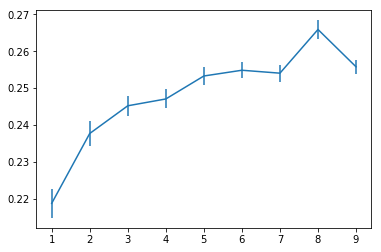

In [208]:
plt.errorbar(range(1,10), mean_errors, yerr=sem_errors)

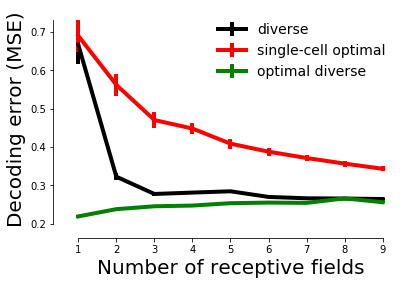

In [210]:
plt.errorbar(range(1, 10), diverse_means, yerr=diverse_errors, color='k', linewidth=4, label='diverse')
plt.errorbar(range(1, 10), homogenous_means, yerr=homogenous_errors, color='r', linewidth=4, label='single-cell optimal')
plt.errorbar(range(1, 10), mean_errors, yerr=sem_errors, color='g', linewidth=4, label='optimal diverse')
adjust_spines(plt.gca())
plt.xlabel('Number of receptive fields', fontsize=20)
plt.ylabel('Decoding error (MSE)', fontsize=20)
plt.legend(fontsize=14, frameon=False, loc='upper right')

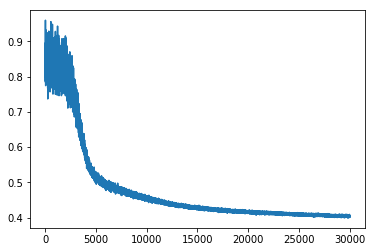

In [211]:
plt.plot(errors)

In [212]:
abs_results = all_results
abs_errors = all_errors
abs_mean_errors = mean_errors
abs_sem_errors = sem_errors

# Going back to MSE, for a longer training period

In [ ]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 100000
mean_errors = []
sem_errors = []
max_channel_depth = 10
all_results = []
all_errors = []

for channel_depth in range(1, max_channel_depth):
    results = collections.defaultdict(list)
    errors = []
    g = tf.Graph()
    with g.as_default():
        # GET DATA READY
        distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
        label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
        # inputs, num_outputs, kernel_size, stride=1

        # GET FILTERS READY
        ideal_horz_weights = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                             initializer=tf.constant_initializer(0.5))
        ideal_center_weights = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                               initializer=tf.constant_initializer(0.5))
        filters = []
        filtered_output = []
        for c in range(channel_depth):
            e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
            filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
        kernel = tf.stack(filters, axis=-1)
        kernel = tf.expand_dims(kernel, axis=1)
        print('Kernel has shape %s.' %(kernel.shape,))

        # CONVOLUTION WITH IDEAL RFS
        encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
        noisy_encoded = encoded + tf.random_normal(shape=encoded.shape, mean=0.0, stddev=output_noise, name='output_noise')
        print('Encoded has shape %s.' %(encoded.shape,))
        print('Noisy encoded has shape %s.' %(noisy_encoded,))

        flattened_input = tf.contrib.layers.flatten(noisy_encoded)
        out = tf.layers.dense(flattened_input, output_len)
        print('Flattened input has shape %s.' %(flattened_input.shape,))
        print('Out has shape %s.' %(out.shape,))
    #     out = tf.layers.dense(layer1, 1)
        # layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
        # layer1 = tf.image.resize_bilinear(layer1, [height, width])
#         mse = tf.losses.absolute_difference(label, tf.squeeze(out))
        mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
        opt = tf.train.GradientDescentOptimizer(0.001)
        train_op = opt.minimize(mse)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for step in tqdm(range(max_steps)):
                x, y = training_data(batch_size)
                update, error, k, hw, cw = sess.run([train_op, mse, kernel, ideal_horz_weights, ideal_center_weights], feed_dict={distortion: x, label: y})
                errors.append(error)
                if step % 10000 == 0:
                    print('Error at step %04d is %0.4f' %(step, error))
                    results['input'].append(x)
                    results['labels'].append(y)
                    output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                    results['output'].append(output)
                    results['kernel'].append(k)
                    results['hw'].append(hw)
                    results['cw'].append(cw)
                elif step == max_steps - 1:
                    print('Error at step %04d is %0.4f' %(step, error))
                    results['input'].append(x)
                    results['labels'].append(y)
                    output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                    results['output'].append(output)
                    results['kernel'].append(k)
                    results['hw'].append(hw)
                    results['cw'].append(cw)

    # Collect results.
    this_mse = np.mean([np.mean(
        (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
    this_err = sem([np.mean(
        (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
    all_results.append(results)
    mean_errors.append(this_mse)
    sem_errors.append(this_err)
    all_errors.append(errors)
    tf.reset_default_graph()



  0%|          | 0/100000 [00:00<?, ?it/s]

Kernel has shape (399, 1, 1).
Encoded has shape (128, 398, 1).
Noisy encoded has shape Tensor("add_4:0", shape=(128, 398, 1), dtype=float32).
Flattened input has shape (128, 398).
Out has shape (128, 398).
Error at step 0000 is 1.0457



 10%|█         | 10004/100000 [04:49<48:56, 30.65it/s] 

Error at step 10000 is 0.2676


 10%|█         | 10389/100000 [05:02<46:01, 32.45it/s]  

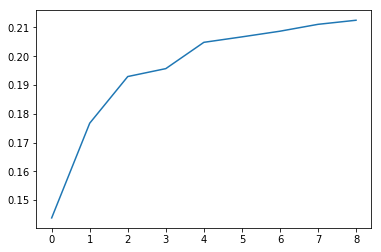

In [222]:
plt.plot(mean_errors)

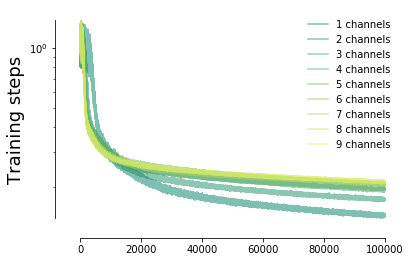

In [231]:
colors = plt.cm.summer(np.linspace(0,1,max_channel_depth))
for i, err in enumerate(all_errors):
    plt.plot(err, color=colors[i], alpha=0.5, label='%d channels' %(i+1))
plt.ylabel('MSE', fontsize=18)
plt.ylabel('Training steps', fontsize=18)
plt.yscale('log')
plt.legend(frameon=False, loc='upper right', fontsize=10)
adjust_spines(plt.gca())

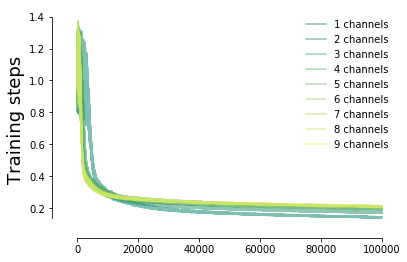

In [232]:
colors = plt.cm.summer(np.linspace(0,1,max_channel_depth))
for i, err in enumerate(all_errors):
    plt.plot(err, color=colors[i], alpha=0.5, label='%d channels' %(i+1))
plt.ylabel('MSE', fontsize=18)
plt.ylabel('Training steps', fontsize=18)
plt.legend(frameon=False, loc='upper right', fontsize=10)
adjust_spines(plt.gca())

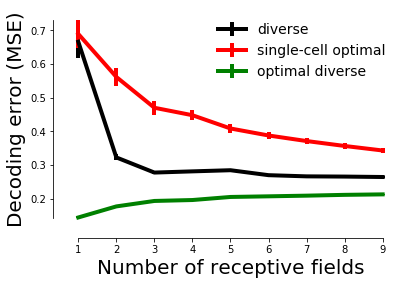

In [233]:
plt.errorbar(range(1, 10), diverse_means, yerr=diverse_errors, color='k', linewidth=4, label='diverse')
plt.errorbar(range(1, 10), homogenous_means, yerr=homogenous_errors, color='r', linewidth=4, label='single-cell optimal')
plt.errorbar(range(1, 10), mean_errors, yerr=sem_errors, color='g', linewidth=4, label='optimal diverse')
adjust_spines(plt.gca())
plt.xlabel('Number of receptive fields', fontsize=20)
plt.ylabel('Decoding error (MSE)', fontsize=20)
plt.legend(fontsize=14, frameon=False, loc='upper right')

In [234]:
mse_results = all_results
mse_errors = all_errors
mse_mean_errors = mean_errors
mse_sem_errors = sem_errors

# Try switching to tranpose convolutions instead of fully connected

In [235]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 1
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET DATA READY
    distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    ideal_horz_weights = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.5))
    ideal_center_weights = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.5))
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
    noisy_encoded = encoded + tf.random_normal(shape=encoded.shape, mean=0.0, stddev=output_noise, name='output_noise')
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    # out = tf.layers.dense(flattened_input, output_len)
    # print('Flattened input has shape %s.' %(flattened_input.shape,))
    
    out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=21, padding='same')
    print('Out has shape %s.' %(out.shape,))
#     out = tf.layers.dense(layer1, 1)
    # layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
    # layer1 = tf.image.resize_bilinear(layer1, [height, width])
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(mse)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw = sess.run([train_op, mse, kernel, ideal_horz_weights, ideal_center_weights], feed_dict={distortion: x, label: y})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)

# Collect results.
this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# np.mean([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# this_err = sem([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 1).
Encoded has shape (128, 398, 1).
Noisy encoded has shape Tensor("add_4:0", shape=(128, 398, 1), dtype=float32).
Out has shape (128, 398, 1).
Error at step 0000 is 0.8294
Error at step 1000 is 0.0916
Error at step 2000 is 0.0666
Error at step 3000 is 0.0517
Error at step 4000 is 0.0418
Error at step 5000 is 0.0355
Error at step 6000 is 0.0310
Error at step 7000 is 0.0310
Error at step 8000 is 0.0278
Error at step 9000 is 0.0255
Error at step 10000 is 0.0265
Error at step 11000 is 0.0254
Error at step 12000 is 0.0246
Error at step 13000 is 0.0258
Error at step 14000 is 0.0254
Error at step 15000 is 0.0254
Error at step 16000 is 0.0253
Error at step 17000 is 0.0244
Error at step 18000 is 0.0247
Error at step 19000 is 0.0247
Error at step 20000 is 0.0238
Error at step 21000 is 0.0229
Error at step 22000 is 0.0248
Error at step 23000 is 0.0258
Error at step 24000 is 0.0235
Error at step 25000 is 0.0250
Error at step 26000 is 0.0257
Error at step 27000 is 0.0243

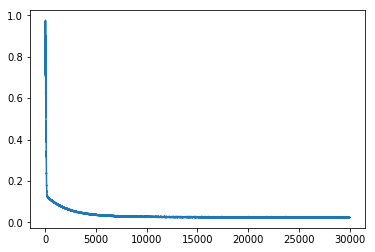

In [236]:
plt.plot(errors)

In [238]:
print("'optimal' hw is %f." %results['hw'][-1])
print("'optimal' cw is %f." %results['cw'][-1])

'optimal' hw is 0.495655.
'optimal' cw is 1.154163.


In [245]:
len(results['output'])

31

In [251]:
np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)

0.023671657302691267

In [252]:
np.mean([np.mean(
    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])

0.33600367522083591

In [254]:
results['output'][-1].shape

(128, 398, 1)

In [255]:
results['labels'][-1].shape

(128, 398)

In [256]:
results['input'][-1].shape

(128, 398, 1)

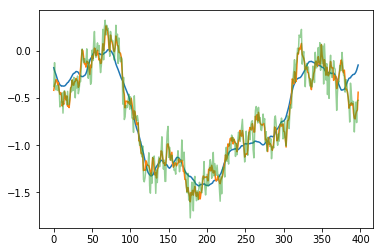

In [262]:
plt.plot(results['output'][-1][0])
plt.plot(results['labels'][-1][0])
plt.plot(results['input'][-1][0], alpha=0.5)

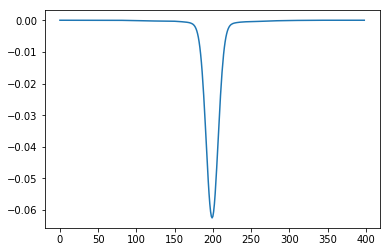

In [260]:
plt.plot(np.squeeze(results['kernel'][-1]))

In [274]:
len(results['kernel'][-1])

399

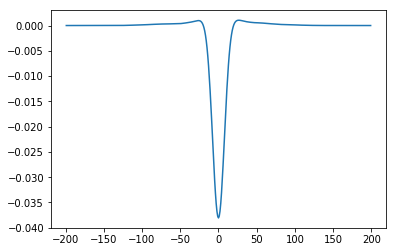

In [275]:
plt.plot(np.linspace(-398/2, 398/2, 399), np.squeeze(results['kernel'][-1]))

In [271]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 1
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET DATA READY
    distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.0))
    cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.0))
    ideal_horz_weights = tf.nn.sigmoid(hw_param)
    ideal_center_weights = tf.nn.sigmoid(cw_param)
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
    noisy_encoded = encoded + tf.random_normal(shape=encoded.shape, mean=0.0, stddev=output_noise, name='output_noise')
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    # out = tf.layers.dense(flattened_input, output_len)
    # print('Flattened input has shape %s.' %(flattened_input.shape,))
    
    out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=21, padding='same', name='decoder')
    variables = tf.get_collection(tf.GraphKeys.VARIABLES)
    weights = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')

    print('Out has shape %s.' %(out.shape,))
#     out = tf.layers.dense(layer1, 1)
    # layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
    # layer1 = tf.image.resize_bilinear(layer1, [height, width])
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(mse)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw, decoder = sess.run(
                [train_op, mse, kernel, ideal_horz_weights, ideal_center_weights, weights],
                feed_dict={distortion: x, label: y})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)

# Collect results.
this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# np.mean([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# this_err = sem([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 1).
Encoded has shape (128, 398, 1).
Noisy encoded has shape Tensor("add_4:0", shape=(128, 398, 1), dtype=float32).
Out has shape (128, 398, 1).
Error at step 0000 is 1.0609
Error at step 1000 is 0.1644
Error at step 2000 is 0.1162
Error at step 3000 is 0.0884
Error at step 4000 is 0.0680
Error at step 5000 is 0.0584
Error at step 6000 is 0.0515
Error at step 7000 is 0.0477
Error at step 8000 is 0.0473
Error at step 9000 is 0.0417
Error at step 10000 is 0.0397
Error at step 11000 is 0.0383
Error at step 12000 is 0.0375
Error at step 13000 is 0.0360
Error at step 14000 is 0.0369
Error at step 15000 is 0.0364
Error at step 16000 is 0.0372
Error at step 17000 is 0.0382
Error at step 18000 is 0.0354
Error at step 19000 is 0.0368
Error at step 20000 is 0.0343
Error at step 21000 is 0.0345
Error at step 22000 is 0.0347
Error at step 23000 is 0.0350
Error at step 24000 is 0.0327
Error at step 25000 is 0.0347
Error at step 26000 is 0.0338
Error at step 27000 is 0.0323

In [272]:
print("'optimal' hw is %f." %results['hw'][-1])
print("'optimal' cw is %f." %results['cw'][-1])

'optimal' hw is 0.499782.
'optimal' cw is 0.809351.


In [ ]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 1
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET DATA READY
    distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.0))
    cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.0))
    ideal_horz_weights = tf.nn.sigmoid(hw_param)
    ideal_center_weights = tf.nn.sigmoid(cw_param)
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
    noisy_encoded = encoded + tf.random_normal(shape=encoded.shape, mean=0.0, stddev=output_noise, name='output_noise')
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    # out = tf.layers.dense(flattened_input, output_len)
    # print('Flattened input has shape %s.' %(flattened_input.shape,))
    
    out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=200, padding='same', name='decoder')
    variables = tf.get_collection(tf.GraphKeys.VARIABLES)
    weights = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')

    print('Out has shape %s.' %(out.shape,))
#     out = tf.layers.dense(layer1, 1)
    # layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
    # layer1 = tf.image.resize_bilinear(layer1, [height, width])
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(mse)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw, decoder = sess.run(
                [train_op, mse, kernel, ideal_horz_weights, ideal_center_weights, weights],
                feed_dict={distortion: x, label: y})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)

# Collect results.
this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# np.mean([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# this_err = sem([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 1).
Encoded has shape (128, 398, 1).
Noisy encoded has shape Tensor("add_4:0", shape=(128, 398, 1), dtype=float32).
Out has shape (128, 398, 1).
Error at step 0000 is 1.0017
Error at step 1000 is 0.1251
Error at step 2000 is 0.0904
Error at step 3000 is 0.0761
Error at step 4000 is 0.0612
Error at step 5000 is 0.0539
Error at step 6000 is 0.0480
Error at step 7000 is 0.0449
Error at step 8000 is 0.0413
Error at step 9000 is 0.0420
Error at step 10000 is 0.0424
Error at step 11000 is 0.0377
Error at step 12000 is 0.0386
Error at step 13000 is 0.0366
Error at step 14000 is 0.0362
Error at step 15000 is 0.0386
Error at step 16000 is 0.0349


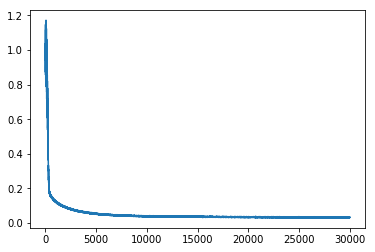

In [277]:
plt.plot(errors)

In [278]:
print("'optimal' hw is %f." %results['hw'][-1])
print("'optimal' cw is %f." %results['cw'][-1])

'optimal' hw is 0.511873.
'optimal' cw is 0.729647.


In [279]:
results['decoder'][-1].shape

(200, 1, 1)

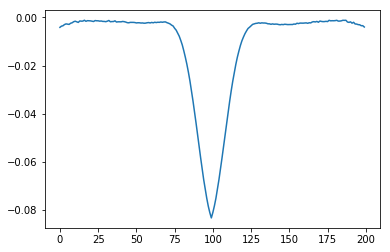

In [280]:
plt.plot(np.squeeze(results['decoder'][-1]))

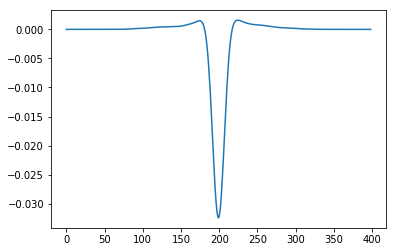

In [288]:
plt.plot(np.squeeze(results['kernel'])[-1])

In [305]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 1
stride = 5
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET DATA READY
    distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, int(output_len/stride) + 1))
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.0))
    cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.0))
    ideal_horz_weights = tf.nn.sigmoid(hw_param)
    ideal_center_weights = tf.nn.sigmoid(cw_param)
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    encoded = tf.nn.conv1d(distortion, kernel, stride=stride, padding='SAME', name='encoded')
    noisy_encoded = encoded + tf.random_normal(shape=encoded.shape, mean=0.0, stddev=output_noise, name='output_noise')
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    # out = tf.layers.dense(flattened_input, output_len)
    # print('Flattened input has shape %s.' %(flattened_input.shape,))
    
    out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=50, padding='same', name='decoder')
    variables = tf.get_collection(tf.GraphKeys.VARIABLES)
    weights = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')

    print('Out has shape %s.' %(out.shape,))
#     out = tf.layers.dense(layer1, 1)
    # layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
    # layer1 = tf.image.resize_bilinear(layer1, [height, width])
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(mse)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw, decoder = sess.run(
                [train_op, mse, kernel, ideal_horz_weights, ideal_center_weights, weights],
                feed_dict={distortion: x, label: y[:,::stride]})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y[:,::stride]})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y[:,::stride]})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)

# Collect results.
this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# np.mean([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# this_err = sem([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 1).
Encoded has shape (128, 80, 1).
Noisy encoded has shape Tensor("add_4:0", shape=(128, 80, 1), dtype=float32).
Out has shape (128, 80, 1).
Error at step 0000 is 0.9842
Error at step 1000 is 0.2005
Error at step 2000 is 0.1458
Error at step 3000 is 0.1183
Error at step 4000 is 0.0972
Error at step 5000 is 0.0880
Error at step 6000 is 0.0835
Error at step 7000 is 0.0736
Error at step 8000 is 0.0720
Error at step 9000 is 0.0727
Error at step 10000 is 0.0680
Error at step 11000 is 0.0657
Error at step 12000 is 0.0643
Error at step 13000 is 0.0645
Error at step 14000 is 0.0647
Error at step 15000 is 0.0642
Error at step 16000 is 0.0585
Error at step 17000 is 0.0584
Error at step 18000 is 0.0605
Error at step 19000 is 0.0587
Error at step 20000 is 0.0597
Error at step 21000 is 0.0545
Error at step 22000 is 0.0605
Error at step 23000 is 0.0575
Error at step 24000 is 0.0542
Error at step 25000 is 0.0604
Error at step 26000 is 0.0606
Error at step 27000 is 0.0583
Er

ValueError: operands could not be broadcast together with shapes (128,80) (128,398) 

In [306]:
print("'optimal' hw is %f." %results['hw'][-1])
print("'optimal' cw is %f." %results['cw'][-1])

'optimal' hw is 0.513181.
'optimal' cw is 0.812676.


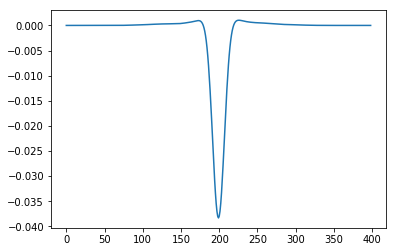

In [307]:
plt.plot(np.squeeze(results['kernel'])[-1])

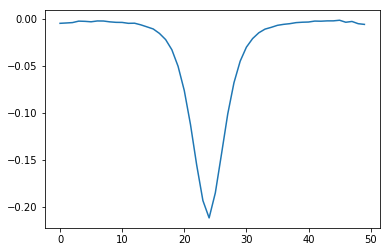

In [308]:
plt.plot(np.squeeze(results['decoder'])[-1])

# Variance

In [317]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 1
stride = 20
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET DATA READY
    distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, int(output_len/stride) + 1))
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.0))
    cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.0))
    ideal_horz_weights = tf.nn.sigmoid(hw_param)
    ideal_center_weights = tf.nn.sigmoid(cw_param)
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    encoded = tf.nn.conv1d(distortion, kernel, stride=stride, padding='SAME', name='encoded')
    noisy_encoded = encoded + tf.random_normal(shape=encoded.shape, mean=0.0, stddev=output_noise, name='output_noise')
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    # out = tf.layers.dense(flattened_input, output_len)
    # print('Flattened input has shape %s.' %(flattened_input.shape,))
    
    out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=50, padding='same', name='decoder')
    variables = tf.get_collection(tf.GraphKeys.VARIABLES)
    weights = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')

    print('Out has shape %s.' %(out.shape,))
#     out = tf.layers.dense(layer1, 1)
    # layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
    # layer1 = tf.image.resize_bilinear(layer1, [height, width])
    # mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    mean, var = tf.nn.moments(label - tf.squeeze(out), axes=[1])
    mse = tf.reduce_mean(tf.log(var))
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(mse)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw, decoder = sess.run(
                [train_op, mse, kernel, ideal_horz_weights, ideal_center_weights, weights],
                feed_dict={distortion: x, label: y[:,::stride]})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y[:,::stride]})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y[:,::stride]})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)

# Collect results.
this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# np.mean([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# this_err = sem([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 1).
Encoded has shape (128, 20, 1).
Noisy encoded has shape Tensor("add_4:0", shape=(128, 20, 1), dtype=float32).
Out has shape (128, 20, 1).
Error at step 0000 is -1.4278
Error at step 1000 is -1.9065
Error at step 2000 is -2.1267
Error at step 3000 is -2.4110
Error at step 4000 is -2.6936
Error at step 5000 is -2.7634
Error at step 6000 is -2.8217
Error at step 7000 is -2.8128
Error at step 8000 is -2.8564
Error at step 9000 is -2.7975
Error at step 10000 is -2.8558
Error at step 11000 is -2.8826
Error at step 12000 is -2.9621
Error at step 13000 is -2.8807
Error at step 14000 is -2.9137
Error at step 15000 is -2.8963
Error at step 16000 is -2.9094
Error at step 17000 is -2.9098
Error at step 18000 is -2.8528
Error at step 19000 is -2.8892
Error at step 20000 is -2.9269
Error at step 21000 is -2.9371
Error at step 22000 is -2.9569
Error at step 23000 is -2.9658
Error at step 24000 is -2.9967
Error at step 25000 is -2.9027
Error at step 26000 is -2.9289
Error

ValueError: operands could not be broadcast together with shapes (128,20) (128,398) 

In [318]:
print("'optimal' hw is %f." %results['hw'][-1])
print("'optimal' cw is %f." %results['cw'][-1])

'optimal' hw is 0.533471.
'optimal' cw is 0.973740.


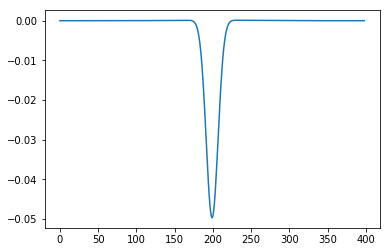

In [319]:
plt.plot(np.squeeze(results['kernel'])[-1])

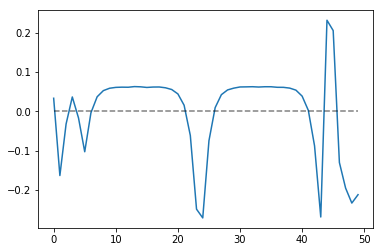

In [320]:
plt.plot(np.squeeze(results['decoder'])[-1])
plt.plot([0]*50, 'k--', alpha=0.5)

# Constrain SNR

In [321]:
from surround.efficient_coding import get_snr

In [324]:
# From notebook Surround - 5-7 All of Figure 3 from scratch
target_snr = 0.26912469

In [328]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 1
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET DATA READY
    distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.0))
    cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.0))
    ideal_horz_weights = tf.nn.sigmoid(hw_param)
    ideal_center_weights = tf.nn.sigmoid(cw_param)
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
    out_noise = tf.random_normal(shape=encoded.shape, mean=0.0, stddev=output_noise, name='output_noise')
    noisy_encoded = encoded + out_noise
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    # out = tf.layers.dense(flattened_input, output_len)
    # print('Flattened input has shape %s.' %(flattened_input.shape,))
    
    out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=200, padding='same', name='decoder')
    variables = tf.get_collection(tf.GraphKeys.VARIABLES)
    weights = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')

    print('Out has shape %s.' %(out.shape,))
#     out = tf.layers.dense(layer1, 1)
    # layer1 = tf.reshape(layer1, shape=[1, height, width, 1])
    # layer1 = tf.image.resize_bilinear(layer1, [height, width])
    signal_mean, signal_var = tf.nn.moments(tf.squeeze(label), axes=[1])
    # noise_mean, noise_var = tf.nn.moments(tf.squeeze(noisy_encoded), axes=[1]) # shouldn't this be input_noise convolved with filter + output_noise?
    # in_noise = tf.constant(input_noise, dtype=tf.float32, shape=tf.squeeze(label).shape)
    in_noise = tf.random_normal(shape=encoded.shape, mean=0.0, stddev=input_noise, name='input_noise')
    all_noise = tf.nn.conv1d(in_noise, kernel, stride=1, padding='SAME', name='noise') + out_noise
    noise_mean, noise_var = tf.nn.moments(tf.squeeze(all_noise), axes=[1])
    #snr = tf.where(tf.equal(noise_var, tf.constant(0.0, dtype=tf.float32)), 0.0, signal_var/noise_var)
    snr = signal_var/noise_var
    snr_regularization = tf.losses.mean_squared_error(tf.constant(target_snr, dtype=tf.float32, shape=snr.shape),
                                                      snr)
    
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    loss = mse + 2. * snr_regularization
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(loss)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw, decoder, this_snr = sess.run(
                [train_op, mse, kernel, ideal_horz_weights, ideal_center_weights, weights, snr],
                feed_dict={distortion: x, label: y})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)

# Collect results.
this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# np.mean([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# this_err = sem([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 1).
Encoded has shape (128, 398, 1).
Noisy encoded has shape Tensor("add_4:0", shape=(128, 398, 1), dtype=float32).
Out has shape (128, 398, 1).
Error at step 0000 is 0.9252
Error at step 1000 is 0.1349
Error at step 2000 is 0.1005
Error at step 3000 is 0.0779
Error at step 4000 is 0.0626
Error at step 5000 is 0.0534
Error at step 6000 is 0.0492
Error at step 7000 is 0.0459
Error at step 8000 is 0.0425
Error at step 9000 is 0.0410
Error at step 10000 is 0.0380
Error at step 11000 is 0.0376
Error at step 12000 is 0.0366
Error at step 13000 is 0.0371
Error at step 14000 is 0.0360
Error at step 15000 is 0.0361
Error at step 16000 is 0.0343
Error at step 17000 is 0.0346
Error at step 18000 is 0.0342
Error at step 19000 is 0.0314
Error at step 20000 is 0.0325
Error at step 21000 is 0.0322
Error at step 22000 is 0.0324
Error at step 23000 is 0.0300
Error at step 24000 is 0.0313
Error at step 25000 is 0.0319
Error at step 26000 is 0.0318
Error at step 27000 is 0.0315

In [329]:
results['snr'][-1]

array([ 1.73523641,  0.55353099,  0.98976433,  2.63795018,  0.75600672,
        0.86810493,  1.87275195,  3.00374866,  3.06381941,  2.57032013,
        1.50535381,  1.78393126,  1.19988823,  0.72916251,  5.91553354,
        1.49202621,  1.08618522,  1.31746554,  0.75099128,  0.83880693,
        1.24390984,  2.48789334,  0.93207914,  2.84842968,  0.86101013,
        1.77026796,  1.76822495,  0.67572105,  5.79053879,  0.55983239,
        0.52552974,  0.7685042 ,  0.62303764,  2.72895241,  1.45692766,
        2.60547256,  0.78656352,  1.56268549,  1.07738984,  2.15688205,
        0.4742862 ,  1.70171297,  1.11587703,  3.57889748,  2.12370062,
        2.23604536,  0.37308508,  1.17242718,  3.82869744,  2.28609824,
        1.6425004 ,  2.15047336,  1.92184484,  0.6062603 ,  0.63256931,
        0.97189707,  1.36501622,  1.58914745,  1.20956004,  0.86557156,
        1.81406474,  1.90742254,  0.68048644,  4.95617008,  1.49129915,
        0.58046424,  3.30204201,  3.20519042,  2.39567733,  2.42

In [330]:
print("'optimal' hw is %f." %results['hw'][-1])
print("'optimal' cw is %f." %results['cw'][-1])

'optimal' hw is 0.517523.
'optimal' cw is 0.768956.


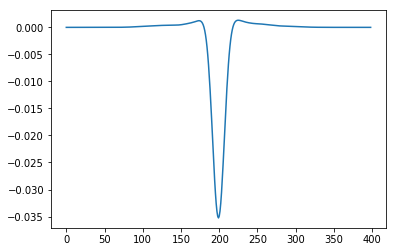

In [333]:
plt.plot(np.squeeze(results['kernel'][-1]))

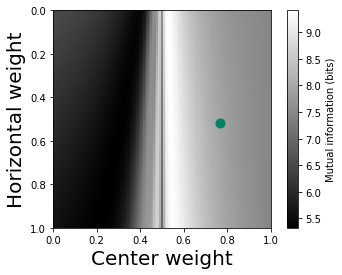

In [331]:
all_hws = results['hw'][-1]
all_cws = results['cw'][-1]

plt.imshow(info_maps[celltype], cmap='gray', extent=(center_weights[0], center_weights[-1], 
                                                     horz_weights[-1], horz_weights[0]))
colors = plt.cm.summer(np.linspace(0,1,max_filters))
for i, cw, hw in zip(range(channel_depth), [max([cw, 0]) for cw in all_cws], all_hws):
    plt.plot(cw, hw, color=colors[i], marker='.', markersize=18)
        
# plt.plot(actual_cws[0], actual_hws[0], color='r', marker='*', markersize=18)
plt.colorbar(label='Mutual information (bits)')
plt.xlabel('Center weight', fontsize=20)
plt.ylabel('Horizontal weight', fontsize=20)

# May also want to use nonlinear decoding, where maximizing information may be more useful, compared to just using a linear readout

In [342]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 1
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET INPUT and OUTPUT NOISE
    n_in = tf.get_variable('noise_in', shape=(1,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(input_noise))
    n_out = tf.get_variable('noise_out', shape=(1,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(output_noise))
    # GET DATA READY
    # distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    in_noise = tf.random_normal(shape=label.shape, mean=0.0, stddev=n_in, name='noisy_input')
    noisy_input = label + in_noise
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.0))
    cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.0))
    ideal_horz_weights = tf.nn.sigmoid(hw_param)
    ideal_center_weights = tf.nn.sigmoid(cw_param)
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        # e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    distortion = tf.expand_dims(noisy_input, axis=-1)
    encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
    out_noise = tf.random_normal(shape=encoded.shape, mean=0.0, stddev=n_out, name='output_noise')
    noisy_encoded = encoded + out_noise
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    # out = tf.layers.dense(flattened_input, output_len)
    # print('Flattened input has shape %s.' %(flattened_input.shape,))
    
    out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=200, padding='same', name='decoder')
    variables = tf.get_collection(tf.GraphKeys.VARIABLES)
    weights = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')
    print('Out has shape %s.' %(out.shape,))
    
    signal_mean, signal_var = tf.nn.moments(
        tf.nn.conv1d(tf.expand_dims(label, axis=-1), kernel, stride=1, padding='SAME'), axes=[1])
    all_noise = tf.nn.conv1d(
        tf.expand_dims(in_noise, axis=-1), kernel, stride=1, padding='SAME', name='noise') + out_noise
    noise_mean, noise_var = tf.nn.moments(tf.squeeze(all_noise), axes=[1])
    snr = signal_var/noise_var
    snr_regularization = tf.losses.mean_squared_error(tf.constant(target_snr, dtype=tf.float32, shape=snr.shape),
                                                      snr)
    
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    loss = mse + 2. * snr_regularization
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(loss)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw, decoder, this_snr, snr_reg, ni, no = sess.run(
                [train_op, mse, kernel, ideal_horz_weights, ideal_center_weights, weights, snr, snr_regularization,
                 n_in, n_out],
                feed_dict={label: y})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)
                results['snr_reg'].append(snr_reg)
                results['input_noise'].append(ni)
                results['output_noise'].append(no)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)
                results['snr_reg'].append(snr_reg)
                results['input_noise'].append(ni)
                results['output_noise'].append(no)

# Collect results.
this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# np.mean([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# this_err = sem([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 1).
Encoded has shape (128, 398, 1).
Noisy encoded has shape Tensor("add_3:0", shape=(128, 398, 1), dtype=float32).
Out has shape (128, 398, 1).
Error at step 0000 is 0.9228
Error at step 1000 is 0.0882
Error at step 2000 is 0.0739
Error at step 3000 is 0.0647
Error at step 4000 is 0.0612
Error at step 5000 is 0.0580
Error at step 6000 is 0.0559
Error at step 7000 is 0.0503
Error at step 8000 is 0.0496
Error at step 9000 is 0.0516
Error at step 10000 is 0.0465
Error at step 11000 is 0.0472
Error at step 12000 is 0.0459
Error at step 13000 is 0.0476
Error at step 14000 is 0.0426
Error at step 15000 is 0.0419
Error at step 16000 is 0.0439
Error at step 17000 is 0.0441
Error at step 18000 is 0.0428
Error at step 19000 is 0.0400
Error at step 20000 is 0.0425
Error at step 21000 is 0.0426
Error at step 22000 is 0.0416


KeyboardInterrupt: 

In [343]:
results['snr'][-1]

array([[ 0.17443579,  0.17650789,  0.16405828, ...,  0.17950362,
         0.1703596 ,  0.18328629],
       [ 0.13245729,  0.13403071,  0.12457715, ...,  0.13630553,
         0.12936203,  0.13917789],
       [ 0.11575479,  0.11712983,  0.10886832, ...,  0.11911778,
         0.11304985,  0.12162795],
       ..., 
       [ 0.1563981 ,  0.15825593,  0.14709368, ...,  0.16094188,
         0.15274341,  0.1643334 ],
       [ 0.33644667,  0.34044325,  0.31643084, ...,  0.34622136,
         0.32858464,  0.35351726],
       [ 0.21284328,  0.21537162,  0.20018084, ...,  0.21902697,
         0.20786959,  0.22364251]], dtype=float32)

In [350]:
np.mean(results['snr'][-1])

0.21583024

In [344]:
results['snr_reg'][-1]

0.017761048

In [345]:
results['input_noise'][-1]

array([ 0.04012606], dtype=float32)

In [346]:
results['output_noise'][-1]

array([ 0.24284503], dtype=float32)

In [347]:
print("'optimal' hw is %f." %results['hw'][-1])
print("'optimal' cw is %f." %results['cw'][-1])

'optimal' hw is 0.489452.
'optimal' cw is 0.574923.


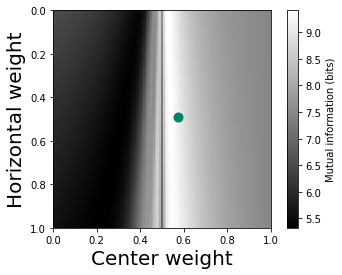

In [349]:
all_hws = results['hw'][-1]
all_cws = results['cw'][-1]

plt.imshow(info_maps[celltype], cmap='gray', extent=(center_weights[0], center_weights[-1], 
                                                     horz_weights[-1], horz_weights[0]))
colors = plt.cm.summer(np.linspace(0,1,max_filters))
for i, cw, hw in zip(range(channel_depth), [max([cw, 0]) for cw in all_cws], all_hws):
    plt.plot(cw, hw, color=colors[i], marker='.', markersize=18)
        
# plt.plot(actual_cws[0], actual_hws[0], color='r', marker='*', markersize=18)
plt.colorbar(label='Mutual information (bits)')
plt.xlabel('Center weight', fontsize=20)
plt.ylabel('Horizontal weight', fontsize=20)

In [348]:
output_noise

0.35

In [351]:
constrained_filter1_results = results

In [352]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 2
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET INPUT and OUTPUT NOISE
    n_in = tf.get_variable('noise_in', shape=(1,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(input_noise))
    n_out = tf.get_variable('noise_out', shape=(1,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(output_noise))
    # GET DATA READY
    # distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    in_noise = tf.random_normal(shape=label.shape, mean=0.0, stddev=n_in, name='noisy_input')
    noisy_input = label + in_noise
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.0))
    cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.0))
    ideal_horz_weights = tf.nn.sigmoid(hw_param)
    ideal_center_weights = tf.nn.sigmoid(cw_param)
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        # e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    distortion = tf.expand_dims(noisy_input, axis=-1)
    encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
    out_noise = tf.random_normal(shape=encoded.shape, mean=0.0, stddev=n_out, name='output_noise')
    noisy_encoded = encoded + out_noise
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    # out = tf.layers.dense(flattened_input, output_len)
    # print('Flattened input has shape %s.' %(flattened_input.shape,))
    
    out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=200, padding='same', name='decoder')
    variables = tf.get_collection(tf.GraphKeys.VARIABLES)
    weights = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')
    print('Out has shape %s.' %(out.shape,))
    
    signal_mean, signal_var = tf.nn.moments(
        tf.nn.conv1d(tf.expand_dims(label, axis=-1), kernel, stride=1, padding='SAME'), axes=[1])
    all_noise = tf.nn.conv1d(
        tf.expand_dims(in_noise, axis=-1), kernel, stride=1, padding='SAME', name='noise') + out_noise
    noise_mean, noise_var = tf.nn.moments(tf.squeeze(all_noise), axes=[1])
    snr = signal_var/noise_var
    snr_regularization = tf.losses.mean_squared_error(tf.constant(target_snr, dtype=tf.float32, shape=snr.shape),
                                                      snr)
    
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    loss = mse + 2. * snr_regularization
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(loss)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw, decoder, this_snr, snr_reg, ni, no = sess.run(
                [train_op, mse, kernel, ideal_horz_weights, ideal_center_weights, weights, snr, snr_regularization,
                 n_in, n_out],
                feed_dict={label: y})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)
                results['snr_reg'].append(snr_reg)
                results['input_noise'].append(ni)
                results['output_noise'].append(no)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)
                results['snr_reg'].append(snr_reg)
                results['input_noise'].append(ni)
                results['output_noise'].append(no)

# Collect results.
this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# np.mean([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# this_err = sem([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 2).
Encoded has shape (128, 398, 2).
Noisy encoded has shape Tensor("add_5:0", shape=(128, 398, 2), dtype=float32).
Out has shape (128, 398, 1).
Error at step 0000 is 0.8180
Error at step 1000 is 0.0839
Error at step 2000 is 0.0705
Error at step 3000 is 0.0681
Error at step 4000 is 0.0581
Error at step 5000 is 0.0569
Error at step 6000 is 0.0551
Error at step 7000 is 0.0538
Error at step 8000 is 0.0482
Error at step 9000 is 0.0474
Error at step 10000 is 0.0437
Error at step 11000 is 0.0440
Error at step 12000 is 0.0405
Error at step 13000 is 0.0394
Error at step 14000 is 0.0381
Error at step 15000 is 0.0374
Error at step 16000 is 0.0374
Error at step 17000 is 0.0350
Error at step 18000 is 0.0344
Error at step 19000 is 0.0357
Error at step 20000 is 0.0342
Error at step 21000 is 0.0334
Error at step 22000 is 0.0312
Error at step 23000 is 0.0323
Error at step 24000 is 0.0316
Error at step 25000 is 0.0316
Error at step 26000 is 0.0311
Error at step 27000 is 0.0322

In [355]:
np.mean(results['snr'][-1])

0.23850752

In [353]:
print("'optimal' hw is %s." %results['hw'][-1])
print("'optimal' cw is %s." %results['cw'][-1])

'optimal' hw is [ 0.47837314  0.49567163].
'optimal' cw is [ 0.56802303  0.56579578].


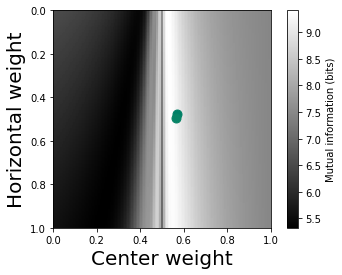

In [354]:
all_hws = results['hw'][-1]
all_cws = results['cw'][-1]

plt.imshow(info_maps[celltype], cmap='gray', extent=(center_weights[0], center_weights[-1], 
                                                     horz_weights[-1], horz_weights[0]))
colors = plt.cm.summer(np.linspace(0,1,max_filters))
for i, cw, hw in zip(range(channel_depth), [max([cw, 0]) for cw in all_cws], all_hws):
    plt.plot(cw, hw, color=colors[i], marker='.', markersize=18)
        
# plt.plot(actual_cws[0], actual_hws[0], color='r', marker='*', markersize=18)
plt.colorbar(label='Mutual information (bits)')
plt.xlabel('Center weight', fontsize=20)
plt.ylabel('Horizontal weight', fontsize=20)

In [360]:
constrained_filter2_results = results

# Try with variable output noise for each channel

In [ ]:
# Universal variables
batch_size = 128
input_len = x.shape[1]
output_len = y.shape[1]
max_steps = 30000
mean_errors = []
sem_errors = []
channel_depth = 2
results = collections.defaultdict(list)

g = tf.Graph()
errors = []
with g.as_default():
    # GET INPUT and OUTPUT NOISE
    n_in = tf.get_variable('noise_in', shape=(1,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(input_noise))
    n_out = tf.get_variable('noise_out', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(output_noise))
    # GET DATA READY
    # distortion = tf.placeholder(tf.float32, shape=(batch_size, input_len, 1))
    label = tf.placeholder(tf.float32, shape=(batch_size, output_len))
    in_noise = tf.random_normal(shape=label.shape, mean=0.0, stddev=n_in, name='noisy_input')
    noisy_input = label + in_noise
    # inputs, num_outputs, kernel_size, stride=1
    
    # GET FILTERS READY
    hw_param = tf.get_variable('horz_weights', shape=(channel_depth,), dtype=tf.float32,
                                         initializer=tf.constant_initializer(0.0))
    cw_param = tf.get_variable('center_weights', shape=(channel_depth,), dtype=tf.float32,
                                           initializer=tf.constant_initializer(0.0))
    ideal_horz_weights = tf.nn.sigmoid(hw_param)
    ideal_center_weights = tf.nn.sigmoid(cw_param)
    filters = []
    filtered_output = []
    for c in range(channel_depth):
        # e = encoder(ideal_horz_weights[c], ideal_center_weights[c])
        filters.append(encoder(ideal_horz_weights[c], ideal_center_weights[c]))
    kernel = tf.stack(filters, axis=-1)
    kernel = tf.expand_dims(kernel, axis=1)
    print('Kernel has shape %s.' %(kernel.shape,))
    
    # CONVOLUTION WITH IDEAL RFS
    distortion = tf.expand_dims(noisy_input, axis=-1)
    encoded = tf.nn.conv1d(distortion, kernel, stride=1, padding='SAME', name='encoded')
    out_noise = tf.random_normal(shape=encoded.shape, mean=0.0, stddev=n_out, name='output_noise')
    noisy_encoded = encoded + out_noise
    print('Encoded has shape %s.' %(encoded.shape,))
    print('Noisy encoded has shape %s.' %(noisy_encoded,))
        
    # flattened_input = tf.contrib.layers.flatten(noisy_encoded)
    # out = tf.layers.dense(flattened_input, output_len)
    # print('Flattened input has shape %s.' %(flattened_input.shape,))
    
    out = tf.layers.conv1d(noisy_encoded, filters=1, kernel_size=200, padding='same', name='decoder')
    variables = tf.get_collection(tf.GraphKeys.VARIABLES)
    weights = tf.get_default_graph().get_tensor_by_name('decoder/kernel:0')
    print('Out has shape %s.' %(out.shape,))
    
    signal_mean, signal_var = tf.nn.moments(
        tf.nn.conv1d(tf.expand_dims(label, axis=-1), kernel, stride=1, padding='SAME'), axes=[1])
    all_noise = tf.nn.conv1d(
        tf.expand_dims(in_noise, axis=-1), kernel, stride=1, padding='SAME', name='noise') + out_noise
    noise_mean, noise_var = tf.nn.moments(tf.squeeze(all_noise), axes=[1])
    snr = signal_var/noise_var
    snr_regularization = tf.losses.mean_squared_error(tf.constant(target_snr, dtype=tf.float32, shape=snr.shape),
                                                      snr)
    
    mse = tf.losses.mean_squared_error(label, tf.squeeze(out))
    loss = mse + 2. * snr_regularization
    opt = tf.train.GradientDescentOptimizer(0.001)
    train_op = opt.minimize(loss)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in range(max_steps):
            x, y = training_data(batch_size)
            update, error, k, hw, cw, decoder, this_snr, snr_reg, ni, no = sess.run(
                [train_op, mse, kernel, ideal_horz_weights, ideal_center_weights, weights, snr, snr_regularization,
                 n_in, n_out],
                feed_dict={label: y})
            errors.append(error)
            if step % 1000 == 0:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)
                results['snr_reg'].append(snr_reg)
                results['input_noise'].append(ni)
                results['output_noise'].append(no)
            elif step == max_steps - 1:
                print('Error at step %04d is %0.4f' %(step, error))
                results['input'].append(x)
                results['labels'].append(y)
                output = sess.run([out], feed_dict={distortion: x, label: y})[0]
                results['output'].append(output)
                results['kernel'].append(k)
                results['hw'].append(hw)
                results['cw'].append(cw)
                results['decoder'].append(decoder)
                results['snr'].append(this_snr)
                results['snr_reg'].append(snr_reg)
                results['input_noise'].append(ni)
                results['output_noise'].append(no)

# Collect results.
this_mse = np.mean((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# np.mean([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])
this_err = sem((np.squeeze(results['output'][-1]) - results['labels'][-1])**2)
# this_err = sem([np.mean(
#    (results['output'][-1][j] - results['labels'][-1][j])**2) for j in range(batch_size)])


Kernel has shape (399, 1, 2).
Encoded has shape (128, 398, 2).
Noisy encoded has shape Tensor("add_5:0", shape=(128, 398, 2), dtype=float32).
Out has shape (128, 398, 1).
Error at step 0000 is 0.9929
Error at step 1000 is 0.0790
